# White Blood Cells Image Classification Using CNN and SOBEL-FILTER

## ABSTRACT:
Detecting blood related diseases is one of the main tasks in todays world. Blood consists of three types of cells and they are Red Blood Cells, White Blood Cells and Platelets. Each type of cells have their own functionalities. Among these to detect and diagnose major diseases like Hemochromatosis, Hemolytic anemia, Hemophilia, etc., we need to identify White Blood Cells(WBCs) and its types. There are five major types of white blood cells. Automated methods to detect and classify white blood cell types have important medical applications. Here I am using, supervised machine learning technique Convolutional Neural Network(CNN) to classify the microscoipic images into one of the five WBC types. I have implemented CNN twice on the dataset. Once on the orginal datset and other I have used CNN on preprocessed dataset using Sobel filter. Sobel filter is a edge detection technique which is used in image processing and computer vision. I am using Sobel's filter to find out what is it's impact on CNN and how is it going to effect CNN. I used confusion matrix and accuracy to know the effect of sobel filter.

### DATASET:
The dataset contains 12,500 augmented images of blood cells (JPEG). There are approximately 3000 images for each of 4 different cell types grouped into 4 different folders (according to cell type). The cell types are Eosinophil, Lymphocyte, Monocyte, and Neutrophil. The folder 'dataset2-master' contains 2,500 augmented images as well as 4 additional subtype labels (JPEG + CSV). There are approximately 3,000 augmented images for each class of the 4 classes. There is also another folder 'dataset-master' which contains 410 images of blood cells with subtype labels and bounding boxes (JPEG + XML). These 410 images are original images(pre-augumentation). In this project I am using dataset2-master as the original images in other dataset have imbalanced class sizes. Our images are of size 320x420.

#### Import librarries that are needed
Some important libraries are OpenCV, Keras, pandas, numpy

## Overall Steps:

1. Analyse the data
2. Create a CNN using keras
3. Train the model using original training dataset and run the model on original test dataset
4. Note the accuracy and confusion matrix
5. Pre-process the images using sobel filter
6. Train the model using this preprocessed data and run the model on preprocessed test dataset
7. Note the accuracy and confusion matrix
8. Comapare both the results

## How to run this project

1. Download the project(Contains the dataset as well in the zip)

2. Run each cell or Run the whole project

In [3]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Lambda, MaxPool2D, BatchNormalization
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import xml.etree.ElementTree as ET
import sklearn
import itertools
import cv2
import scipy
import os
import csv
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
#Define all the celltypes in a dictionary
cell_types = {1:'NEUTROPHIL',2:'EOSINOPHIL',3:'MONOCYTE',4:'LYMPHOCYTE'}

#### A Function to import and load the data from dataset
The get_data function that loops through all the folders and appends the label according to the type of the cell. For example if an image is in folder NEUTOPHIL it appends the label 1. We are using CV2 library's imread() method to read a image from folder and conver it to array. Once we get the array we will use scipy's imresize() method to resize the image to 60x80 from 320x420.

In [66]:
#Loading the data 
from tqdm import tqdm
#tqdm is to show the progress of detting data from images
def get_data(folder):
    X = []
    y = []
    for wbc_type in os.listdir(folder):
        if not wbc_type.startswith('.'):
            if wbc_type in ['NEUTROPHIL']:
                label = 1

            elif wbc_type in ['EOSINOPHIL']:
                label = 2

            elif wbc_type in ['MONOCYTE']:
                label = 3  

            elif wbc_type in ['LYMPHOCYTE']:
                label = 4 
            else:
                label = 5
            for image_filename in tqdm(os.listdir(folder + wbc_type)):
                img_file = cv2.imread(folder + wbc_type + '/' + image_filename)
                if img_file is not None:
                    img_file = scipy.misc.imresize(arr=img_file, size=(60, 80, 3))
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)

    X = np.asarray(X)
    y = np.asarray(y)
    return X,y

#### Load the data using the above function
And encode the labels to one hot encoded variables. That means if there are 5 labels we will have 5 one hot encoded variables.

In [6]:
X_train, y_train = get_data('../dataset2-master/images/TRAIN/')
X_test, y_test = get_data('../dataset2-master/images/TEST/')

# Encode labels to one hot encoded variables 
from keras.utils.np_utils import to_categorical
y_trainHot = to_categorical(y_train, num_classes = 5)
y_testHot = to_categorical(y_test, num_classes = 5)

print(cell_types)

  0%|                                                                                         | 0/2497 [00:00<?, ?it/s]C:\Users\balak\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
100%|███████████████████████████████████████████████████████████████████████████████| 624/624 [00:02<00:00, 311.16it/s]


{1: 'NEUTROPHIL', 2: 'EOSINOPHIL', 3: 'MONOCYTE', 4: 'LYMPHOCYTE'}


{1: 'NEUTROPHIL', 2: 'EOSINOPHIL', 3: 'MONOCYTE', 4: 'LYMPHOCYTE'}


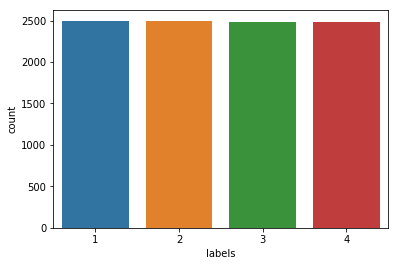

In [7]:
#Plotting the label counts
import seaborn as sns
df = pd.DataFrame()
df["labels"]=y_train
lab = df['labels']
dist = lab.value_counts()
sns.countplot(lab)
print(cell_types)

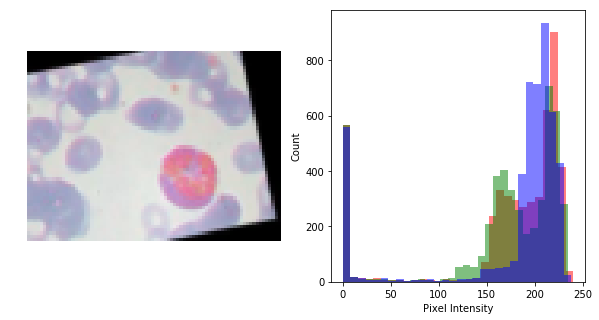

In [9]:
 #Function to plot Histogram indicating pixel Intensity    
    def plotHistogram(a):
        """
        Plot histogram of RGB Pixel Intensities
        """
        plt.figure(figsize=(10,5))
        plt.subplot(1,2,1)
        plt.imshow(a)
        plt.axis('off')
        histo = plt.subplot(1,2,2)
        histo.set_ylabel('Count')
        histo.set_xlabel('Pixel Intensity')
        n_bins = 30
        plt.hist(a[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
        plt.hist(a[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5);
        plt.hist(a[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5);
    plotHistogram(X_train[1])

#### Scaling down image pixel intensity to 0 to 1

In [10]:
X_train=np.array(X_train)
X_train=X_train/255.0

X_test=np.array(X_test)
X_test=X_test/255.0

We can see that it didn't effect the image but the pixe intensity is between 0 to 1.

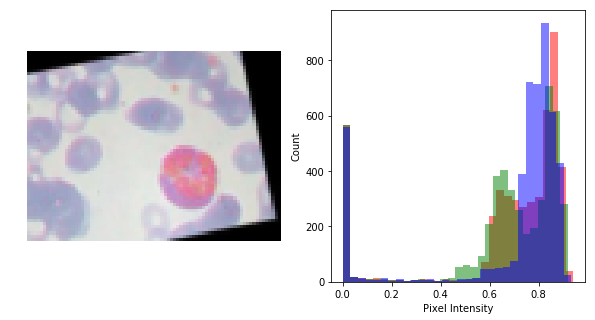

In [11]:
plotHistogram(X_train[1])

### Writing functions for callbacks 

In [12]:
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

## Function to plot confusion Matrix
Reference - https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

In [58]:
#Reference - https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
#This function prints and plots the confusion matrix. Normalization can be applied by setting `normalize=True`.
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


#### Function to plot learning curve of the model
This function takes CNNs fit_generator as argument

In [59]:
def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    #plt.clf()
    # summarize history for loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./loss_curve.png')

## Funtion for Keras CNN 

In this we are using the Sequential model and adding Conv2D layer, actionlayer RELU, and defining number of epochs as 30 and defining batch size. We are calling the callback function we have defined earlier. Getting the accuracy after every epoch and overall accuarcy as well. Calling the function to plot confusion matrix and learning curve after all the epoch are done.  

In [64]:
def runKerasCNNAugment(a,b,c,d,e):
    batch_size = 128
    num_classes = len(b[0])
    epochs = 30
#     img_rows, img_cols = a.shape[1],a.shape[2]
    img_rows,img_cols=60,80
    input_shape = (img_rows, img_cols, 3)
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape,strides=e))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images
    history = model.fit_generator(datagen.flow(a,b, batch_size=32),
                        steps_per_epoch=len(a) / 32, epochs=epochs, validation_data = [c, d],callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(c,d, verbose=0)
    print('\nKeras CNN #1C - accuracy:', score[1],'\n')
    y_pred = model.predict(c)
    map_characters = cell_types
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')    
    Y_pred_classes = np.argmax(y_pred,axis=1) 
    Y_true = np.argmax(d,axis=1)
    #plotKerasLearningCurve()
    plt.show()  
    plot_learning_curve(history)
    plt.show()
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(cell_types.values())) 
    plt.show()

## Running the CNN on original dataset

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/30
204/311 [==================>...........] - ETA: 7:57 - loss: 1.6058 - acc: 0.156 - ETA: 5:37 - loss: 4.1861 - acc: 0.250 - ETA: 4:51 - loss: 4.2147 - acc: 0.239 - ETA: 4:25 - loss: 3.5040 - acc: 0.265 - ETA: 4:07 - loss: 3.1002 - acc: 0.281 - ETA: 3:56 - loss: 2.8291 - acc: 0.281 - ETA: 3:46 - loss: 2.6353 - acc: 0.290 - ETA: 3:40 - loss: 2.4924 - acc: 0.277 - ETA: 3:35 - loss: 2.3671 - acc: 0.274 - ETA: 3:31 - loss: 2.2737 - acc: 0.268 - ETA: 3:27 - loss: 2.1907 - acc: 0.278 - ETA: 3:24 - loss: 2.1276 - acc: 0.286 - ETA: 3:23 - loss: 2.0902 - acc: 0.278 - ETA: 3:21 - loss: 2.0412 - acc: 0.285 - ETA: 3:19 - loss: 2.0002 - acc: 0.283 - ETA: 3:17 - loss: 1.9638 - acc: 0.287 - ETA: 3:15 - loss: 1.9343 - acc: 0.279 - ETA: 3:13 - loss: 1.9072 - acc:

204/311 [==================>...........] - ETA: 3:22 - loss: 1.4163 - acc: 0.218 - ETA: 3:20 - loss: 1.3965 - acc: 0.296 - ETA: 3:20 - loss: 1.3940 - acc: 0.281 - ETA: 3:18 - loss: 1.3918 - acc: 0.257 - ETA: 3:18 - loss: 1.3982 - acc: 0.237 - ETA: 3:17 - loss: 1.4017 - acc: 0.218 - ETA: 3:16 - loss: 1.4053 - acc: 0.218 - ETA: 3:15 - loss: 1.4067 - acc: 0.222 - ETA: 3:16 - loss: 1.4054 - acc: 0.229 - ETA: 3:17 - loss: 1.4030 - acc: 0.234 - ETA: 3:20 - loss: 1.4062 - acc: 0.230 - ETA: 3:21 - loss: 1.4021 - acc: 0.247 - ETA: 3:21 - loss: 1.4097 - acc: 0.233 - ETA: 3:22 - loss: 1.4080 - acc: 0.229 - ETA: 3:21 - loss: 1.4062 - acc: 0.231 - ETA: 3:22 - loss: 1.4065 - acc: 0.230 - ETA: 3:20 - loss: 1.4060 - acc: 0.231 - ETA: 3:19 - loss: 1.4041 - acc: 0.232 - ETA: 3:18 - loss: 1.4024 - acc: 0.236 - ETA: 3:17 - loss: 1.4024 - acc: 0.235 - ETA: 3:16 - loss: 1.4013 - acc: 0.241 - ETA: 3:15 - loss: 1.3997 - acc: 0.242 - ETA: 3:14 - loss: 1.4014 - acc: 0.236 - ETA: 3:13 - loss: 1.4020 - acc: 0.231

312/311 [==============================] - ETA: 1:12 - loss: 1.3851 - acc: 0.283 - ETA: 1:11 - loss: 1.3848 - acc: 0.284 - ETA: 1:10 - loss: 1.3848 - acc: 0.284 - ETA: 1:10 - loss: 1.3850 - acc: 0.284 - ETA: 1:09 - loss: 1.3847 - acc: 0.284 - ETA: 1:08 - loss: 1.3847 - acc: 0.283 - ETA: 1:07 - loss: 1.3843 - acc: 0.285 - ETA: 1:07 - loss: 1.3841 - acc: 0.285 - ETA: 1:06 - loss: 1.3837 - acc: 0.285 - ETA: 1:05 - loss: 1.3831 - acc: 0.286 - ETA: 1:05 - loss: 1.3830 - acc: 0.286 - ETA: 1:04 - loss: 1.3829 - acc: 0.286 - ETA: 1:03 - loss: 1.3830 - acc: 0.286 - ETA: 1:03 - loss: 1.3829 - acc: 0.286 - ETA: 1:02 - loss: 1.3830 - acc: 0.286 - ETA: 1:01 - loss: 1.3830 - acc: 0.286 - ETA: 1:01 - loss: 1.3829 - acc: 0.286 - ETA: 1:00 - loss: 1.3828 - acc: 0.286 - ETA: 59s - loss: 1.3824 - acc: 0.287 - ETA: 59s - loss: 1.3824 - acc: 0.28 - ETA: 58s - loss: 1.3823 - acc: 0.28 - ETA: 57s - loss: 1.3822 - acc: 0.28 - ETA: 56s - loss: 1.3825 - acc: 0.28 - ETA: 56s - loss: 1.3823 - acc: 0.28 - ETA: 55s

204/311 [==================>...........] - ETA: 3:18 - loss: 1.3571 - acc: 0.281 - ETA: 3:17 - loss: 1.3357 - acc: 0.296 - ETA: 3:34 - loss: 1.2995 - acc: 0.343 - ETA: 3:33 - loss: 1.2770 - acc: 0.367 - ETA: 3:39 - loss: 1.2416 - acc: 0.400 - ETA: 3:35 - loss: 1.2565 - acc: 0.375 - ETA: 3:33 - loss: 1.2435 - acc: 0.401 - ETA: 3:32 - loss: 1.2484 - acc: 0.402 - ETA: 3:31 - loss: 1.2339 - acc: 0.416 - ETA: 3:30 - loss: 1.2440 - acc: 0.409 - ETA: 3:29 - loss: 1.2429 - acc: 0.400 - ETA: 3:28 - loss: 1.2347 - acc: 0.421 - ETA: 3:28 - loss: 1.2365 - acc: 0.415 - ETA: 3:27 - loss: 1.2360 - acc: 0.410 - ETA: 3:27 - loss: 1.2317 - acc: 0.412 - ETA: 3:26 - loss: 1.2315 - acc: 0.410 - ETA: 3:24 - loss: 1.2306 - acc: 0.411 - ETA: 3:23 - loss: 1.2407 - acc: 0.406 - ETA: 3:22 - loss: 1.2359 - acc: 0.409 - ETA: 3:21 - loss: 1.2389 - acc: 0.406 - ETA: 3:20 - loss: 1.2381 - acc: 0.406 - ETA: 3:19 - loss: 1.2396 - acc: 0.404 - ETA: 3:18 - loss: 1.2401 - acc: 0.409 - ETA: 3:16 - loss: 1.2424 - acc: 0.410

312/311 [==============================] - ETA: 1:11 - loss: 1.2272 - acc: 0.425 - ETA: 1:10 - loss: 1.2269 - acc: 0.426 - ETA: 1:10 - loss: 1.2266 - acc: 0.426 - ETA: 1:09 - loss: 1.2264 - acc: 0.426 - ETA: 1:08 - loss: 1.2264 - acc: 0.426 - ETA: 1:08 - loss: 1.2265 - acc: 0.426 - ETA: 1:07 - loss: 1.2270 - acc: 0.425 - ETA: 1:06 - loss: 1.2262 - acc: 0.426 - ETA: 1:06 - loss: 1.2260 - acc: 0.426 - ETA: 1:05 - loss: 1.2259 - acc: 0.426 - ETA: 1:04 - loss: 1.2243 - acc: 0.427 - ETA: 1:04 - loss: 1.2234 - acc: 0.428 - ETA: 1:03 - loss: 1.2220 - acc: 0.429 - ETA: 1:02 - loss: 1.2216 - acc: 0.429 - ETA: 1:02 - loss: 1.2211 - acc: 0.429 - ETA: 1:01 - loss: 1.2213 - acc: 0.429 - ETA: 1:00 - loss: 1.2233 - acc: 0.428 - ETA: 59s - loss: 1.2245 - acc: 0.428 - ETA: 59s - loss: 1.2251 - acc: 0.42 - ETA: 58s - loss: 1.2246 - acc: 0.42 - ETA: 57s - loss: 1.2243 - acc: 0.42 - ETA: 57s - loss: 1.2242 - acc: 0.42 - ETA: 56s - loss: 1.2255 - acc: 0.42 - ETA: 55s - loss: 1.2258 - acc: 0.42 - ETA: 55s -

204/311 [==================>...........] - ETA: 3:31 - loss: 2.0936 - acc: 0.218 - ETA: 3:28 - loss: 1.7154 - acc: 0.312 - ETA: 3:20 - loss: 1.5972 - acc: 0.343 - ETA: 3:18 - loss: 1.5188 - acc: 0.390 - ETA: 3:16 - loss: 1.4381 - acc: 0.431 - ETA: 3:15 - loss: 1.3897 - acc: 0.442 - ETA: 3:14 - loss: 1.3624 - acc: 0.455 - ETA: 3:13 - loss: 1.3458 - acc: 0.437 - ETA: 3:12 - loss: 1.3044 - acc: 0.458 - ETA: 3:10 - loss: 1.2810 - acc: 0.459 - ETA: 3:09 - loss: 1.2555 - acc: 0.465 - ETA: 3:08 - loss: 1.2288 - acc: 0.479 - ETA: 3:08 - loss: 1.2156 - acc: 0.490 - ETA: 3:07 - loss: 1.2118 - acc: 0.488 - ETA: 3:07 - loss: 1.2060 - acc: 0.495 - ETA: 3:06 - loss: 1.2005 - acc: 0.498 - ETA: 3:06 - loss: 1.2014 - acc: 0.485 - ETA: 3:05 - loss: 1.1953 - acc: 0.480 - ETA: 3:04 - loss: 1.1866 - acc: 0.485 - ETA: 3:03 - loss: 1.1804 - acc: 0.487 - ETA: 3:02 - loss: 1.1899 - acc: 0.477 - ETA: 3:01 - loss: 1.1841 - acc: 0.477 - ETA: 3:00 - loss: 1.1880 - acc: 0.470 - ETA: 3:00 - loss: 1.1783 - acc: 0.474

312/311 [==============================] - ETA: 1:14 - loss: 1.0603 - acc: 0.525 - ETA: 1:13 - loss: 1.0613 - acc: 0.524 - ETA: 1:12 - loss: 1.0604 - acc: 0.524 - ETA: 1:12 - loss: 1.0594 - acc: 0.524 - ETA: 1:11 - loss: 1.0589 - acc: 0.525 - ETA: 1:10 - loss: 1.0579 - acc: 0.525 - ETA: 1:09 - loss: 1.0589 - acc: 0.524 - ETA: 1:09 - loss: 1.0597 - acc: 0.523 - ETA: 1:08 - loss: 1.0592 - acc: 0.523 - ETA: 1:07 - loss: 1.0584 - acc: 0.524 - ETA: 1:07 - loss: 1.0589 - acc: 0.523 - ETA: 1:06 - loss: 1.0591 - acc: 0.524 - ETA: 1:05 - loss: 1.0596 - acc: 0.523 - ETA: 1:04 - loss: 1.0587 - acc: 0.524 - ETA: 1:04 - loss: 1.0587 - acc: 0.524 - ETA: 1:03 - loss: 1.0599 - acc: 0.523 - ETA: 1:02 - loss: 1.0594 - acc: 0.523 - ETA: 1:02 - loss: 1.0597 - acc: 0.523 - ETA: 1:01 - loss: 1.0600 - acc: 0.523 - ETA: 1:00 - loss: 1.0603 - acc: 0.523 - ETA: 59s - loss: 1.0604 - acc: 0.522 - ETA: 59s - loss: 1.0603 - acc: 0.52 - ETA: 58s - loss: 1.0605 - acc: 0.52 - ETA: 57s - loss: 1.0598 - acc: 0.52 - ETA:

204/311 [==================>...........] - ETA: 3:05 - loss: 1.0205 - acc: 0.593 - ETA: 3:04 - loss: 0.8635 - acc: 0.687 - ETA: 3:04 - loss: 0.8589 - acc: 0.666 - ETA: 3:03 - loss: 0.8709 - acc: 0.664 - ETA: 3:03 - loss: 0.8772 - acc: 0.631 - ETA: 3:03 - loss: 0.8671 - acc: 0.625 - ETA: 3:03 - loss: 0.8723 - acc: 0.611 - ETA: 3:03 - loss: 0.8826 - acc: 0.597 - ETA: 3:05 - loss: 0.8611 - acc: 0.611 - ETA: 3:04 - loss: 0.8843 - acc: 0.603 - ETA: 3:04 - loss: 0.8721 - acc: 0.610 - ETA: 3:03 - loss: 0.8792 - acc: 0.604 - ETA: 3:02 - loss: 0.8744 - acc: 0.608 - ETA: 3:01 - loss: 0.8775 - acc: 0.607 - ETA: 3:01 - loss: 0.8662 - acc: 0.612 - ETA: 3:00 - loss: 0.8830 - acc: 0.611 - ETA: 3:00 - loss: 0.8926 - acc: 0.608 - ETA: 3:00 - loss: 0.8851 - acc: 0.616 - ETA: 3:00 - loss: 0.8749 - acc: 0.618 - ETA: 2:59 - loss: 0.8826 - acc: 0.606 - ETA: 2:58 - loss: 0.8791 - acc: 0.605 - ETA: 2:58 - loss: 0.8720 - acc: 0.606 - ETA: 2:57 - loss: 0.8668 - acc: 0.608 - ETA: 2:57 - loss: 0.8627 - acc: 0.610

312/311 [==============================] - ETA: 1:05 - loss: 0.8617 - acc: 0.608 - ETA: 1:05 - loss: 0.8619 - acc: 0.609 - ETA: 1:04 - loss: 0.8612 - acc: 0.609 - ETA: 1:03 - loss: 0.8611 - acc: 0.609 - ETA: 1:03 - loss: 0.8603 - acc: 0.609 - ETA: 1:02 - loss: 0.8594 - acc: 0.610 - ETA: 1:01 - loss: 0.8583 - acc: 0.611 - ETA: 1:01 - loss: 0.8568 - acc: 0.612 - ETA: 1:00 - loss: 0.8562 - acc: 0.612 - ETA: 1:00 - loss: 0.8553 - acc: 0.612 - ETA: 59s - loss: 0.8553 - acc: 0.612 - ETA: 59s - loss: 0.8565 - acc: 0.61 - ETA: 58s - loss: 0.8560 - acc: 0.61 - ETA: 57s - loss: 0.8552 - acc: 0.61 - ETA: 57s - loss: 0.8546 - acc: 0.61 - ETA: 56s - loss: 0.8546 - acc: 0.61 - ETA: 56s - loss: 0.8557 - acc: 0.61 - ETA: 55s - loss: 0.8593 - acc: 0.61 - ETA: 54s - loss: 0.8598 - acc: 0.61 - ETA: 54s - loss: 0.8603 - acc: 0.61 - ETA: 53s - loss: 0.8598 - acc: 0.61 - ETA: 53s - loss: 0.8590 - acc: 0.61 - ETA: 52s - loss: 0.8597 - acc: 0.61 - ETA: 51s - loss: 0.8606 - acc: 0.61 - ETA: 51s - loss: 0.8605 

204/311 [==================>...........] - ETA: 3:33 - loss: 0.6519 - acc: 0.718 - ETA: 3:44 - loss: 0.6673 - acc: 0.703 - ETA: 3:57 - loss: 0.6773 - acc: 0.697 - ETA: 4:09 - loss: 0.7031 - acc: 0.695 - ETA: 4:14 - loss: 0.6694 - acc: 0.712 - ETA: 4:16 - loss: 0.6686 - acc: 0.718 - ETA: 4:15 - loss: 0.6629 - acc: 0.718 - ETA: 4:10 - loss: 0.6779 - acc: 0.710 - ETA: 4:10 - loss: 0.6818 - acc: 0.691 - ETA: 4:05 - loss: 0.6954 - acc: 0.678 - ETA: 4:01 - loss: 0.7139 - acc: 0.681 - ETA: 3:57 - loss: 0.7408 - acc: 0.679 - ETA: 3:53 - loss: 0.7488 - acc: 0.668 - ETA: 3:49 - loss: 0.7402 - acc: 0.669 - ETA: 3:45 - loss: 0.7405 - acc: 0.675 - ETA: 3:41 - loss: 0.7316 - acc: 0.671 - ETA: 3:39 - loss: 0.7298 - acc: 0.676 - ETA: 3:36 - loss: 0.7301 - acc: 0.682 - ETA: 3:34 - loss: 0.7320 - acc: 0.682 - ETA: 3:31 - loss: 0.7345 - acc: 0.676 - ETA: 3:29 - loss: 0.7310 - acc: 0.677 - ETA: 3:27 - loss: 0.7374 - acc: 0.673 - ETA: 3:25 - loss: 0.7356 - acc: 0.671 - ETA: 3:24 - loss: 0.7367 - acc: 0.668

312/311 [==============================] - ETA: 1:06 - loss: 0.7361 - acc: 0.680 - ETA: 1:05 - loss: 0.7361 - acc: 0.680 - ETA: 1:05 - loss: 0.7347 - acc: 0.680 - ETA: 1:04 - loss: 0.7334 - acc: 0.681 - ETA: 1:04 - loss: 0.7334 - acc: 0.681 - ETA: 1:03 - loss: 0.7333 - acc: 0.682 - ETA: 1:02 - loss: 0.7328 - acc: 0.682 - ETA: 1:02 - loss: 0.7349 - acc: 0.681 - ETA: 1:01 - loss: 0.7353 - acc: 0.681 - ETA: 1:00 - loss: 0.7357 - acc: 0.680 - ETA: 1:00 - loss: 0.7353 - acc: 0.681 - ETA: 59s - loss: 0.7353 - acc: 0.681 - ETA: 58s - loss: 0.7345 - acc: 0.68 - ETA: 58s - loss: 0.7344 - acc: 0.68 - ETA: 57s - loss: 0.7336 - acc: 0.68 - ETA: 57s - loss: 0.7339 - acc: 0.68 - ETA: 56s - loss: 0.7335 - acc: 0.68 - ETA: 55s - loss: 0.7327 - acc: 0.68 - ETA: 55s - loss: 0.7325 - acc: 0.68 - ETA: 54s - loss: 0.7315 - acc: 0.68 - ETA: 53s - loss: 0.7309 - acc: 0.68 - ETA: 53s - loss: 0.7313 - acc: 0.68 - ETA: 52s - loss: 0.7316 - acc: 0.68 - ETA: 52s - loss: 0.7308 - acc: 0.68 - ETA: 51s - loss: 0.730

204/311 [==================>...........] - ETA: 3:11 - loss: 0.6050 - acc: 0.781 - ETA: 3:06 - loss: 0.6354 - acc: 0.765 - ETA: 3:08 - loss: 0.7681 - acc: 0.708 - ETA: 3:07 - loss: 0.8245 - acc: 0.671 - ETA: 3:06 - loss: 0.8258 - acc: 0.668 - ETA: 3:05 - loss: 0.8380 - acc: 0.677 - ETA: 3:04 - loss: 0.8604 - acc: 0.665 - ETA: 3:03 - loss: 0.8318 - acc: 0.675 - ETA: 3:03 - loss: 0.8228 - acc: 0.680 - ETA: 3:03 - loss: 0.8218 - acc: 0.675 - ETA: 3:02 - loss: 0.8316 - acc: 0.664 - ETA: 3:01 - loss: 0.8342 - acc: 0.656 - ETA: 3:01 - loss: 0.8315 - acc: 0.653 - ETA: 3:00 - loss: 0.8158 - acc: 0.662 - ETA: 3:00 - loss: 0.7997 - acc: 0.662 - ETA: 3:00 - loss: 0.7970 - acc: 0.666 - ETA: 2:59 - loss: 0.7902 - acc: 0.671 - ETA: 2:59 - loss: 0.7917 - acc: 0.666 - ETA: 2:58 - loss: 0.7740 - acc: 0.674 - ETA: 2:57 - loss: 0.7582 - acc: 0.678 - ETA: 2:57 - loss: 0.7464 - acc: 0.681 - ETA: 2:56 - loss: 0.7417 - acc: 0.681 - ETA: 2:55 - loss: 0.7368 - acc: 0.684 - ETA: 2:54 - loss: 0.7421 - acc: 0.683

312/311 [==============================] - ETA: 1:10 - loss: 0.6607 - acc: 0.722 - ETA: 1:09 - loss: 0.6608 - acc: 0.722 - ETA: 1:09 - loss: 0.6619 - acc: 0.722 - ETA: 1:08 - loss: 0.6619 - acc: 0.722 - ETA: 1:07 - loss: 0.6609 - acc: 0.722 - ETA: 1:07 - loss: 0.6602 - acc: 0.722 - ETA: 1:06 - loss: 0.6603 - acc: 0.722 - ETA: 1:05 - loss: 0.6594 - acc: 0.722 - ETA: 1:04 - loss: 0.6586 - acc: 0.723 - ETA: 1:04 - loss: 0.6589 - acc: 0.722 - ETA: 1:03 - loss: 0.6597 - acc: 0.721 - ETA: 1:03 - loss: 0.6592 - acc: 0.722 - ETA: 1:02 - loss: 0.6587 - acc: 0.722 - ETA: 1:01 - loss: 0.6587 - acc: 0.722 - ETA: 1:01 - loss: 0.6576 - acc: 0.723 - ETA: 1:00 - loss: 0.6566 - acc: 0.723 - ETA: 59s - loss: 0.6558 - acc: 0.723 - ETA: 59s - loss: 0.6556 - acc: 0.72 - ETA: 58s - loss: 0.6558 - acc: 0.72 - ETA: 57s - loss: 0.6564 - acc: 0.72 - ETA: 57s - loss: 0.6557 - acc: 0.72 - ETA: 56s - loss: 0.6549 - acc: 0.72 - ETA: 55s - loss: 0.6544 - acc: 0.72 - ETA: 55s - loss: 0.6536 - acc: 0.72 - ETA: 54s - l

204/311 [==================>...........] - ETA: 3:08 - loss: 0.9300 - acc: 0.687 - ETA: 3:13 - loss: 0.7997 - acc: 0.640 - ETA: 3:15 - loss: 0.8157 - acc: 0.645 - ETA: 3:15 - loss: 0.7530 - acc: 0.703 - ETA: 3:14 - loss: 0.7091 - acc: 0.718 - ETA: 3:12 - loss: 0.6689 - acc: 0.744 - ETA: 3:11 - loss: 0.6219 - acc: 0.758 - ETA: 3:10 - loss: 0.6149 - acc: 0.753 - ETA: 3:11 - loss: 0.6148 - acc: 0.746 - ETA: 3:12 - loss: 0.6133 - acc: 0.753 - ETA: 3:13 - loss: 0.6154 - acc: 0.747 - ETA: 3:12 - loss: 0.6068 - acc: 0.750 - ETA: 3:11 - loss: 0.6153 - acc: 0.738 - ETA: 3:09 - loss: 0.6139 - acc: 0.738 - ETA: 3:08 - loss: 0.6030 - acc: 0.741 - ETA: 3:07 - loss: 0.6055 - acc: 0.742 - ETA: 3:06 - loss: 0.5945 - acc: 0.744 - ETA: 3:06 - loss: 0.5885 - acc: 0.750 - ETA: 3:05 - loss: 0.5764 - acc: 0.754 - ETA: 3:05 - loss: 0.5746 - acc: 0.754 - ETA: 3:04 - loss: 0.5727 - acc: 0.756 - ETA: 3:05 - loss: 0.5737 - acc: 0.752 - ETA: 3:07 - loss: 0.5667 - acc: 0.758 - ETA: 3:09 - loss: 0.5596 - acc: 0.761

312/311 [==============================] - ETA: 1:08 - loss: 0.5709 - acc: 0.762 - ETA: 1:08 - loss: 0.5710 - acc: 0.762 - ETA: 1:07 - loss: 0.5704 - acc: 0.762 - ETA: 1:06 - loss: 0.5700 - acc: 0.762 - ETA: 1:06 - loss: 0.5692 - acc: 0.763 - ETA: 1:05 - loss: 0.5689 - acc: 0.763 - ETA: 1:04 - loss: 0.5689 - acc: 0.763 - ETA: 1:04 - loss: 0.5693 - acc: 0.762 - ETA: 1:03 - loss: 0.5686 - acc: 0.763 - ETA: 1:03 - loss: 0.5675 - acc: 0.763 - ETA: 1:02 - loss: 0.5669 - acc: 0.764 - ETA: 1:01 - loss: 0.5663 - acc: 0.764 - ETA: 1:01 - loss: 0.5664 - acc: 0.764 - ETA: 1:00 - loss: 0.5668 - acc: 0.764 - ETA: 59s - loss: 0.5673 - acc: 0.764 - ETA: 59s - loss: 0.5672 - acc: 0.76 - ETA: 58s - loss: 0.5666 - acc: 0.76 - ETA: 57s - loss: 0.5653 - acc: 0.76 - ETA: 57s - loss: 0.5647 - acc: 0.76 - ETA: 56s - loss: 0.5641 - acc: 0.76 - ETA: 55s - loss: 0.5639 - acc: 0.76 - ETA: 55s - loss: 0.5647 - acc: 0.76 - ETA: 54s - loss: 0.5656 - acc: 0.76 - ETA: 53s - loss: 0.5652 - acc: 0.76 - ETA: 53s - loss:

204/311 [==================>...........] - ETA: 3:14 - loss: 1.9878 - acc: 0.343 - ETA: 3:15 - loss: 1.4449 - acc: 0.453 - ETA: 3:12 - loss: 1.2226 - acc: 0.489 - ETA: 3:12 - loss: 1.0570 - acc: 0.554 - ETA: 3:12 - loss: 0.9491 - acc: 0.618 - ETA: 3:10 - loss: 0.8676 - acc: 0.656 - ETA: 3:10 - loss: 0.8163 - acc: 0.674 - ETA: 3:09 - loss: 0.7838 - acc: 0.679 - ETA: 3:08 - loss: 0.7539 - acc: 0.691 - ETA: 3:07 - loss: 0.7143 - acc: 0.712 - ETA: 3:07 - loss: 0.6950 - acc: 0.715 - ETA: 3:07 - loss: 0.6740 - acc: 0.721 - ETA: 3:08 - loss: 0.6515 - acc: 0.730 - ETA: 3:09 - loss: 0.6285 - acc: 0.734 - ETA: 3:10 - loss: 0.6183 - acc: 0.735 - ETA: 3:10 - loss: 0.6181 - acc: 0.734 - ETA: 3:10 - loss: 0.6084 - acc: 0.740 - ETA: 3:10 - loss: 0.5913 - acc: 0.748 - ETA: 3:12 - loss: 0.5773 - acc: 0.758 - ETA: 3:17 - loss: 0.5731 - acc: 0.760 - ETA: 3:18 - loss: 0.5635 - acc: 0.766 - ETA: 3:18 - loss: 0.5541 - acc: 0.769 - ETA: 3:16 - loss: 0.5457 - acc: 0.774 - ETA: 3:15 - loss: 0.5416 - acc: 0.774

312/311 [==============================] - ETA: 1:08 - loss: 0.4994 - acc: 0.792 - ETA: 1:07 - loss: 0.4994 - acc: 0.792 - ETA: 1:07 - loss: 0.4993 - acc: 0.792 - ETA: 1:06 - loss: 0.4986 - acc: 0.793 - ETA: 1:05 - loss: 0.4980 - acc: 0.793 - ETA: 1:05 - loss: 0.4982 - acc: 0.793 - ETA: 1:04 - loss: 0.4984 - acc: 0.793 - ETA: 1:04 - loss: 0.4983 - acc: 0.793 - ETA: 1:03 - loss: 0.4995 - acc: 0.793 - ETA: 1:03 - loss: 0.4997 - acc: 0.793 - ETA: 1:02 - loss: 0.4993 - acc: 0.793 - ETA: 1:01 - loss: 0.5009 - acc: 0.793 - ETA: 1:01 - loss: 0.5006 - acc: 0.793 - ETA: 1:00 - loss: 0.5018 - acc: 0.792 - ETA: 59s - loss: 0.5011 - acc: 0.792 - ETA: 59s - loss: 0.5014 - acc: 0.79 - ETA: 58s - loss: 0.5025 - acc: 0.79 - ETA: 57s - loss: 0.5035 - acc: 0.79 - ETA: 57s - loss: 0.5042 - acc: 0.79 - ETA: 56s - loss: 0.5036 - acc: 0.79 - ETA: 56s - loss: 0.5025 - acc: 0.79 - ETA: 55s - loss: 0.5020 - acc: 0.79 - ETA: 54s - loss: 0.5033 - acc: 0.79 - ETA: 54s - loss: 0.5030 - acc: 0.79 - ETA: 53s - loss:

204/311 [==================>...........] - ETA: 3:19 - loss: 0.7590 - acc: 0.687 - ETA: 3:19 - loss: 0.6656 - acc: 0.703 - ETA: 3:18 - loss: 0.5674 - acc: 0.760 - ETA: 3:18 - loss: 0.5602 - acc: 0.757 - ETA: 3:21 - loss: 0.5102 - acc: 0.787 - ETA: 3:21 - loss: 0.4846 - acc: 0.796 - ETA: 3:20 - loss: 0.4817 - acc: 0.803 - ETA: 3:18 - loss: 0.4647 - acc: 0.808 - ETA: 3:20 - loss: 0.4477 - acc: 0.822 - ETA: 3:21 - loss: 0.4273 - acc: 0.834 - ETA: 3:19 - loss: 0.4443 - acc: 0.826 - ETA: 3:18 - loss: 0.4376 - acc: 0.830 - ETA: 3:17 - loss: 0.4429 - acc: 0.824 - ETA: 3:15 - loss: 0.4607 - acc: 0.817 - ETA: 3:14 - loss: 0.4553 - acc: 0.822 - ETA: 3:12 - loss: 0.4458 - acc: 0.826 - ETA: 3:11 - loss: 0.4517 - acc: 0.819 - ETA: 3:10 - loss: 0.4495 - acc: 0.819 - ETA: 3:09 - loss: 0.4490 - acc: 0.817 - ETA: 3:08 - loss: 0.4501 - acc: 0.814 - ETA: 3:07 - loss: 0.4583 - acc: 0.811 - ETA: 3:06 - loss: 0.4583 - acc: 0.808 - ETA: 3:05 - loss: 0.4612 - acc: 0.805 - ETA: 3:05 - loss: 0.4550 - acc: 0.808

312/311 [==============================] - ETA: 1:07 - loss: 0.4708 - acc: 0.803 - ETA: 1:06 - loss: 0.4701 - acc: 0.804 - ETA: 1:06 - loss: 0.4703 - acc: 0.803 - ETA: 1:05 - loss: 0.4704 - acc: 0.803 - ETA: 1:04 - loss: 0.4698 - acc: 0.804 - ETA: 1:04 - loss: 0.4690 - acc: 0.804 - ETA: 1:03 - loss: 0.4681 - acc: 0.804 - ETA: 1:03 - loss: 0.4679 - acc: 0.804 - ETA: 1:02 - loss: 0.4672 - acc: 0.804 - ETA: 1:01 - loss: 0.4669 - acc: 0.804 - ETA: 1:01 - loss: 0.4667 - acc: 0.804 - ETA: 1:00 - loss: 0.4660 - acc: 0.804 - ETA: 59s - loss: 0.4656 - acc: 0.805 - ETA: 59s - loss: 0.4647 - acc: 0.80 - ETA: 58s - loss: 0.4637 - acc: 0.80 - ETA: 57s - loss: 0.4643 - acc: 0.80 - ETA: 57s - loss: 0.4654 - acc: 0.80 - ETA: 56s - loss: 0.4656 - acc: 0.80 - ETA: 55s - loss: 0.4663 - acc: 0.80 - ETA: 55s - loss: 0.4659 - acc: 0.80 - ETA: 54s - loss: 0.4657 - acc: 0.80 - ETA: 54s - loss: 0.4657 - acc: 0.80 - ETA: 53s - loss: 0.4652 - acc: 0.80 - ETA: 52s - loss: 0.4654 - acc: 0.80 - ETA: 52s - loss: 0.4

204/311 [==================>...........] - ETA: 3:06 - loss: 0.4454 - acc: 0.812 - ETA: 3:08 - loss: 0.4407 - acc: 0.812 - ETA: 3:07 - loss: 0.4346 - acc: 0.822 - ETA: 3:07 - loss: 0.3857 - acc: 0.859 - ETA: 3:07 - loss: 0.4305 - acc: 0.825 - ETA: 3:06 - loss: 0.4523 - acc: 0.802 - ETA: 3:06 - loss: 0.4532 - acc: 0.785 - ETA: 3:05 - loss: 0.4473 - acc: 0.777 - ETA: 3:05 - loss: 0.4421 - acc: 0.781 - ETA: 3:05 - loss: 0.4369 - acc: 0.784 - ETA: 3:04 - loss: 0.4156 - acc: 0.801 - ETA: 3:03 - loss: 0.4068 - acc: 0.807 - ETA: 3:03 - loss: 0.4197 - acc: 0.805 - ETA: 3:03 - loss: 0.4125 - acc: 0.805 - ETA: 3:02 - loss: 0.4044 - acc: 0.812 - ETA: 3:01 - loss: 0.4015 - acc: 0.812 - ETA: 3:01 - loss: 0.3923 - acc: 0.821 - ETA: 3:00 - loss: 0.3917 - acc: 0.821 - ETA: 3:00 - loss: 0.3901 - acc: 0.820 - ETA: 2:59 - loss: 0.3856 - acc: 0.825 - ETA: 2:59 - loss: 0.3875 - acc: 0.824 - ETA: 2:58 - loss: 0.3868 - acc: 0.823 - ETA: 2:57 - loss: 0.3846 - acc: 0.826 - ETA: 2:57 - loss: 0.3903 - acc: 0.824

312/311 [==============================] - ETA: 1:10 - loss: 0.4332 - acc: 0.817 - ETA: 1:09 - loss: 0.4334 - acc: 0.817 - ETA: 1:08 - loss: 0.4326 - acc: 0.817 - ETA: 1:08 - loss: 0.4324 - acc: 0.817 - ETA: 1:07 - loss: 0.4313 - acc: 0.817 - ETA: 1:06 - loss: 0.4306 - acc: 0.817 - ETA: 1:06 - loss: 0.4303 - acc: 0.817 - ETA: 1:05 - loss: 0.4303 - acc: 0.817 - ETA: 1:04 - loss: 0.4313 - acc: 0.817 - ETA: 1:04 - loss: 0.4309 - acc: 0.817 - ETA: 1:03 - loss: 0.4312 - acc: 0.817 - ETA: 1:02 - loss: 0.4314 - acc: 0.817 - ETA: 1:02 - loss: 0.4317 - acc: 0.818 - ETA: 1:01 - loss: 0.4311 - acc: 0.818 - ETA: 1:00 - loss: 0.4321 - acc: 0.817 - ETA: 1:00 - loss: 0.4318 - acc: 0.817 - ETA: 59s - loss: 0.4314 - acc: 0.817 - ETA: 58s - loss: 0.4309 - acc: 0.81 - ETA: 58s - loss: 0.4313 - acc: 0.81 - ETA: 57s - loss: 0.4327 - acc: 0.81 - ETA: 56s - loss: 0.4327 - acc: 0.81 - ETA: 56s - loss: 0.4323 - acc: 0.81 - ETA: 55s - loss: 0.4314 - acc: 0.81 - ETA: 54s - loss: 0.4312 - acc: 0.81 - ETA: 54s - l

204/311 [==================>...........] - ETA: 3:13 - loss: 0.2227 - acc: 0.937 - ETA: 3:14 - loss: 0.2811 - acc: 0.906 - ETA: 3:17 - loss: 0.2799 - acc: 0.906 - ETA: 3:26 - loss: 0.3011 - acc: 0.898 - ETA: 3:29 - loss: 0.3048 - acc: 0.893 - ETA: 3:29 - loss: 0.3005 - acc: 0.901 - ETA: 3:27 - loss: 0.3001 - acc: 0.897 - ETA: 3:25 - loss: 0.2783 - acc: 0.906 - ETA: 3:23 - loss: 0.2872 - acc: 0.899 - ETA: 3:20 - loss: 0.2859 - acc: 0.896 - ETA: 3:18 - loss: 0.2885 - acc: 0.894 - ETA: 3:16 - loss: 0.2957 - acc: 0.888 - ETA: 3:15 - loss: 0.2987 - acc: 0.889 - ETA: 3:13 - loss: 0.3122 - acc: 0.888 - ETA: 3:12 - loss: 0.3156 - acc: 0.891 - ETA: 3:11 - loss: 0.3135 - acc: 0.890 - ETA: 3:10 - loss: 0.3412 - acc: 0.884 - ETA: 3:09 - loss: 0.3604 - acc: 0.875 - ETA: 3:08 - loss: 0.4547 - acc: 0.843 - ETA: 3:07 - loss: 0.4420 - acc: 0.848 - ETA: 3:06 - loss: 0.4348 - acc: 0.849 - ETA: 3:06 - loss: 0.4316 - acc: 0.852 - ETA: 3:05 - loss: 0.4332 - acc: 0.845 - ETA: 3:04 - loss: 0.4369 - acc: 0.841

312/311 [==============================] - ETA: 1:08 - loss: 0.3845 - acc: 0.845 - ETA: 1:07 - loss: 0.3856 - acc: 0.845 - ETA: 1:07 - loss: 0.3855 - acc: 0.845 - ETA: 1:06 - loss: 0.3859 - acc: 0.845 - ETA: 1:06 - loss: 0.3852 - acc: 0.845 - ETA: 1:05 - loss: 0.3850 - acc: 0.845 - ETA: 1:04 - loss: 0.3849 - acc: 0.845 - ETA: 1:04 - loss: 0.3843 - acc: 0.845 - ETA: 1:03 - loss: 0.3838 - acc: 0.845 - ETA: 1:02 - loss: 0.3838 - acc: 0.845 - ETA: 1:02 - loss: 0.3830 - acc: 0.845 - ETA: 1:01 - loss: 0.3825 - acc: 0.845 - ETA: 1:00 - loss: 0.3840 - acc: 0.844 - ETA: 1:00 - loss: 0.3860 - acc: 0.844 - ETA: 59s - loss: 0.3860 - acc: 0.844 - ETA: 59s - loss: 0.3870 - acc: 0.84 - ETA: 58s - loss: 0.3877 - acc: 0.84 - ETA: 57s - loss: 0.3881 - acc: 0.84 - ETA: 57s - loss: 0.3881 - acc: 0.84 - ETA: 56s - loss: 0.3877 - acc: 0.84 - ETA: 56s - loss: 0.3873 - acc: 0.84 - ETA: 55s - loss: 0.3881 - acc: 0.84 - ETA: 54s - loss: 0.3883 - acc: 0.84 - ETA: 54s - loss: 0.3881 - acc: 0.84 - ETA: 53s - loss:

204/311 [==================>...........] - ETA: 3:25 - loss: 0.2501 - acc: 0.843 - ETA: 3:20 - loss: 0.3031 - acc: 0.828 - ETA: 3:17 - loss: 0.2805 - acc: 0.843 - ETA: 3:16 - loss: 0.3246 - acc: 0.835 - ETA: 3:14 - loss: 0.3427 - acc: 0.825 - ETA: 3:13 - loss: 0.3086 - acc: 0.843 - ETA: 3:12 - loss: 0.3182 - acc: 0.839 - ETA: 3:11 - loss: 0.3175 - acc: 0.835 - ETA: 3:11 - loss: 0.3181 - acc: 0.843 - ETA: 3:12 - loss: 0.3175 - acc: 0.850 - ETA: 3:11 - loss: 0.3160 - acc: 0.849 - ETA: 3:13 - loss: 0.3258 - acc: 0.854 - ETA: 3:13 - loss: 0.3397 - acc: 0.846 - ETA: 3:12 - loss: 0.3446 - acc: 0.843 - ETA: 3:11 - loss: 0.3461 - acc: 0.845 - ETA: 3:10 - loss: 0.3433 - acc: 0.847 - ETA: 3:08 - loss: 0.3473 - acc: 0.849 - ETA: 3:07 - loss: 0.3558 - acc: 0.845 - ETA: 3:06 - loss: 0.3525 - acc: 0.843 - ETA: 3:05 - loss: 0.3548 - acc: 0.845 - ETA: 3:05 - loss: 0.3531 - acc: 0.846 - ETA: 3:04 - loss: 0.3497 - acc: 0.845 - ETA: 3:03 - loss: 0.3512 - acc: 0.847 - ETA: 3:02 - loss: 0.3672 - acc: 0.845

312/311 [==============================] - ETA: 1:08 - loss: 0.3644 - acc: 0.854 - ETA: 1:07 - loss: 0.3649 - acc: 0.853 - ETA: 1:06 - loss: 0.3646 - acc: 0.854 - ETA: 1:06 - loss: 0.3648 - acc: 0.853 - ETA: 1:05 - loss: 0.3646 - acc: 0.854 - ETA: 1:04 - loss: 0.3636 - acc: 0.854 - ETA: 1:04 - loss: 0.3631 - acc: 0.854 - ETA: 1:03 - loss: 0.3633 - acc: 0.854 - ETA: 1:03 - loss: 0.3636 - acc: 0.854 - ETA: 1:02 - loss: 0.3629 - acc: 0.855 - ETA: 1:01 - loss: 0.3628 - acc: 0.855 - ETA: 1:01 - loss: 0.3623 - acc: 0.855 - ETA: 1:00 - loss: 0.3621 - acc: 0.855 - ETA: 59s - loss: 0.3617 - acc: 0.855 - ETA: 59s - loss: 0.3622 - acc: 0.85 - ETA: 58s - loss: 0.3623 - acc: 0.85 - ETA: 57s - loss: 0.3621 - acc: 0.85 - ETA: 57s - loss: 0.3610 - acc: 0.85 - ETA: 56s - loss: 0.3608 - acc: 0.85 - ETA: 55s - loss: 0.3606 - acc: 0.85 - ETA: 55s - loss: 0.3609 - acc: 0.85 - ETA: 54s - loss: 0.3609 - acc: 0.85 - ETA: 53s - loss: 0.3605 - acc: 0.85 - ETA: 53s - loss: 0.3599 - acc: 0.85 - ETA: 52s - loss: 0

204/311 [==================>...........] - ETA: 3:13 - loss: 0.1443 - acc: 0.906 - ETA: 3:14 - loss: 0.2549 - acc: 0.890 - ETA: 3:13 - loss: 0.2625 - acc: 0.885 - ETA: 3:11 - loss: 0.2507 - acc: 0.882 - ETA: 3:11 - loss: 0.2735 - acc: 0.887 - ETA: 3:10 - loss: 0.2980 - acc: 0.880 - ETA: 3:10 - loss: 0.2966 - acc: 0.883 - ETA: 3:09 - loss: 0.2956 - acc: 0.886 - ETA: 3:09 - loss: 0.2903 - acc: 0.885 - ETA: 3:08 - loss: 0.3022 - acc: 0.881 - ETA: 3:07 - loss: 0.2988 - acc: 0.883 - ETA: 3:07 - loss: 0.2906 - acc: 0.890 - ETA: 3:06 - loss: 0.2953 - acc: 0.889 - ETA: 3:06 - loss: 0.3077 - acc: 0.881 - ETA: 3:05 - loss: 0.3008 - acc: 0.881 - ETA: 3:04 - loss: 0.3074 - acc: 0.878 - ETA: 3:04 - loss: 0.3250 - acc: 0.875 - ETA: 3:03 - loss: 0.3191 - acc: 0.880 - ETA: 3:03 - loss: 0.3171 - acc: 0.879 - ETA: 3:02 - loss: 0.3141 - acc: 0.879 - ETA: 3:02 - loss: 0.3104 - acc: 0.881 - ETA: 3:01 - loss: 0.3125 - acc: 0.877 - ETA: 3:00 - loss: 0.3205 - acc: 0.872 - ETA: 2:59 - loss: 0.3201 - acc: 0.873

312/311 [==============================] - ETA: 1:10 - loss: 0.3522 - acc: 0.862 - ETA: 1:09 - loss: 0.3527 - acc: 0.862 - ETA: 1:09 - loss: 0.3523 - acc: 0.862 - ETA: 1:08 - loss: 0.3514 - acc: 0.863 - ETA: 1:07 - loss: 0.3510 - acc: 0.863 - ETA: 1:07 - loss: 0.3504 - acc: 0.863 - ETA: 1:06 - loss: 0.3497 - acc: 0.863 - ETA: 1:06 - loss: 0.3486 - acc: 0.864 - ETA: 1:05 - loss: 0.3485 - acc: 0.864 - ETA: 1:04 - loss: 0.3493 - acc: 0.864 - ETA: 1:04 - loss: 0.3509 - acc: 0.863 - ETA: 1:03 - loss: 0.3510 - acc: 0.863 - ETA: 1:02 - loss: 0.3527 - acc: 0.862 - ETA: 1:02 - loss: 0.3551 - acc: 0.861 - ETA: 1:01 - loss: 0.3560 - acc: 0.861 - ETA: 1:01 - loss: 0.3571 - acc: 0.861 - ETA: 1:00 - loss: 0.3594 - acc: 0.861 - ETA: 59s - loss: 0.3596 - acc: 0.861 - ETA: 59s - loss: 0.3590 - acc: 0.86 - ETA: 58s - loss: 0.3586 - acc: 0.86 - ETA: 58s - loss: 0.3581 - acc: 0.86 - ETA: 57s - loss: 0.3571 - acc: 0.86 - ETA: 56s - loss: 0.3585 - acc: 0.86 - ETA: 56s - loss: 0.3588 - acc: 0.86 - ETA: 55s -

204/311 [==================>...........] - ETA: 4:31 - loss: 0.2894 - acc: 0.937 - ETA: 4:13 - loss: 0.3662 - acc: 0.890 - ETA: 3:54 - loss: 0.3298 - acc: 0.885 - ETA: 3:43 - loss: 0.3162 - acc: 0.882 - ETA: 3:36 - loss: 0.3268 - acc: 0.875 - ETA: 3:31 - loss: 0.3259 - acc: 0.869 - ETA: 3:29 - loss: 0.3319 - acc: 0.866 - ETA: 3:26 - loss: 0.3218 - acc: 0.867 - ETA: 3:24 - loss: 0.3054 - acc: 0.875 - ETA: 3:22 - loss: 0.2923 - acc: 0.881 - ETA: 3:20 - loss: 0.2887 - acc: 0.880 - ETA: 3:18 - loss: 0.3358 - acc: 0.859 - ETA: 3:17 - loss: 0.3833 - acc: 0.851 - ETA: 3:16 - loss: 0.4080 - acc: 0.837 - ETA: 3:15 - loss: 0.5021 - acc: 0.816 - ETA: 3:13 - loss: 0.8838 - acc: 0.783 - ETA: 3:12 - loss: 1.2300 - acc: 0.755 - ETA: 3:11 - loss: 1.2483 - acc: 0.739 - ETA: 3:10 - loss: 1.2421 - acc: 0.730 - ETA: 3:09 - loss: 1.2348 - acc: 0.718 - ETA: 3:08 - loss: 1.2194 - acc: 0.720 - ETA: 3:07 - loss: 1.1999 - acc: 0.718 - ETA: 3:06 - loss: 1.1621 - acc: 0.726 - ETA: 3:05 - loss: 1.1523 - acc: 0.722

312/311 [==============================] - ETA: 1:12 - loss: 0.4212 - acc: 0.858 - ETA: 1:11 - loss: 0.4215 - acc: 0.858 - ETA: 1:10 - loss: 0.4218 - acc: 0.857 - ETA: 1:10 - loss: 0.4209 - acc: 0.858 - ETA: 1:09 - loss: 0.4206 - acc: 0.858 - ETA: 1:08 - loss: 0.4208 - acc: 0.858 - ETA: 1:07 - loss: 0.4208 - acc: 0.857 - ETA: 1:07 - loss: 0.4213 - acc: 0.857 - ETA: 1:06 - loss: 0.4207 - acc: 0.857 - ETA: 1:05 - loss: 0.4214 - acc: 0.857 - ETA: 1:05 - loss: 0.4205 - acc: 0.857 - ETA: 1:04 - loss: 0.4200 - acc: 0.857 - ETA: 1:03 - loss: 0.4202 - acc: 0.857 - ETA: 1:03 - loss: 0.4209 - acc: 0.857 - ETA: 1:02 - loss: 0.4211 - acc: 0.856 - ETA: 1:01 - loss: 0.4205 - acc: 0.856 - ETA: 1:00 - loss: 0.4202 - acc: 0.856 - ETA: 1:00 - loss: 0.4208 - acc: 0.856 - ETA: 59s - loss: 0.4212 - acc: 0.855 - ETA: 58s - loss: 0.4248 - acc: 0.85 - ETA: 58s - loss: 0.4292 - acc: 0.85 - ETA: 57s - loss: 0.4316 - acc: 0.85 - ETA: 56s - loss: 0.4324 - acc: 0.85 - ETA: 56s - loss: 0.4338 - acc: 0.85 - ETA: 55s

204/311 [==================>...........] - ETA: 3:38 - loss: 1.0733 - acc: 0.875 - ETA: 3:43 - loss: 0.5811 - acc: 0.937 - ETA: 3:37 - loss: 0.4798 - acc: 0.947 - ETA: 3:30 - loss: 0.4440 - acc: 0.921 - ETA: 3:26 - loss: 0.4008 - acc: 0.918 - ETA: 3:22 - loss: 0.3623 - acc: 0.921 - ETA: 3:20 - loss: 0.3483 - acc: 0.915 - ETA: 3:17 - loss: 0.3639 - acc: 0.902 - ETA: 3:17 - loss: 0.3546 - acc: 0.902 - ETA: 3:17 - loss: 0.3491 - acc: 0.900 - ETA: 3:16 - loss: 0.3394 - acc: 0.903 - ETA: 3:16 - loss: 0.3431 - acc: 0.901 - ETA: 3:15 - loss: 0.3358 - acc: 0.894 - ETA: 3:16 - loss: 0.3350 - acc: 0.888 - ETA: 3:15 - loss: 0.3305 - acc: 0.889 - ETA: 3:16 - loss: 0.3262 - acc: 0.886 - ETA: 3:18 - loss: 0.3259 - acc: 0.884 - ETA: 3:19 - loss: 0.3262 - acc: 0.878 - ETA: 3:20 - loss: 0.3245 - acc: 0.876 - ETA: 3:21 - loss: 0.3142 - acc: 0.882 - ETA: 3:22 - loss: 0.3127 - acc: 0.882 - ETA: 3:23 - loss: 0.3147 - acc: 0.882 - ETA: 3:23 - loss: 0.3258 - acc: 0.880 - ETA: 3:23 - loss: 0.3471 - acc: 0.878

312/311 [==============================] - ETA: 1:12 - loss: 0.3321 - acc: 0.871 - ETA: 1:12 - loss: 0.3317 - acc: 0.871 - ETA: 1:11 - loss: 0.3317 - acc: 0.871 - ETA: 1:10 - loss: 0.3316 - acc: 0.871 - ETA: 1:09 - loss: 0.3313 - acc: 0.871 - ETA: 1:09 - loss: 0.3309 - acc: 0.871 - ETA: 1:08 - loss: 0.3312 - acc: 0.871 - ETA: 1:07 - loss: 0.3308 - acc: 0.871 - ETA: 1:07 - loss: 0.3301 - acc: 0.871 - ETA: 1:06 - loss: 0.3296 - acc: 0.871 - ETA: 1:05 - loss: 0.3286 - acc: 0.872 - ETA: 1:04 - loss: 0.3277 - acc: 0.872 - ETA: 1:04 - loss: 0.3267 - acc: 0.872 - ETA: 1:03 - loss: 0.3258 - acc: 0.873 - ETA: 1:02 - loss: 0.3249 - acc: 0.873 - ETA: 1:02 - loss: 0.3242 - acc: 0.873 - ETA: 1:01 - loss: 0.3241 - acc: 0.873 - ETA: 1:00 - loss: 0.3237 - acc: 0.873 - ETA: 1:00 - loss: 0.3245 - acc: 0.872 - ETA: 59s - loss: 0.3245 - acc: 0.872 - ETA: 58s - loss: 0.3250 - acc: 0.87 - ETA: 57s - loss: 0.3252 - acc: 0.87 - ETA: 57s - loss: 0.3255 - acc: 0.87 - ETA: 56s - loss: 0.3247 - acc: 0.87 - ETA: 5

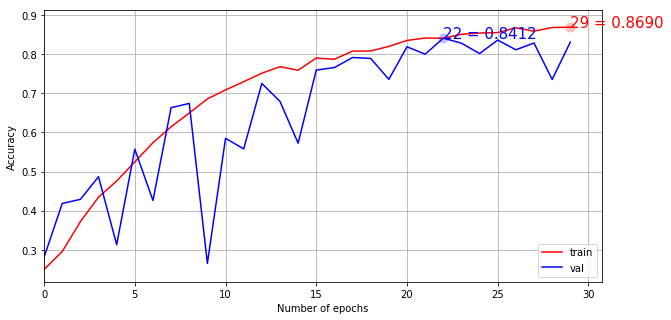

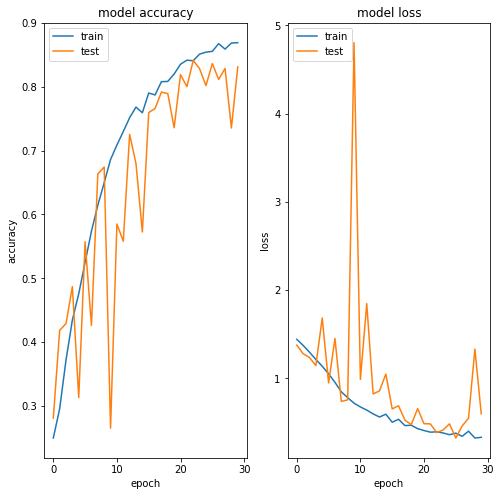

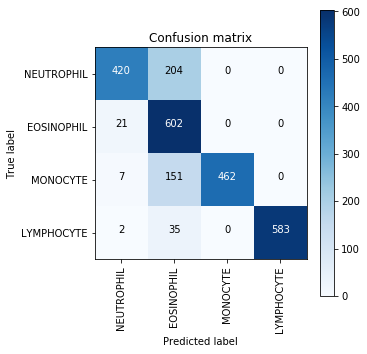

In [34]:
runKerasCNNAugment(X_train,y_trainHot,X_test,y_testHot,1)

## Result:

On the original data we got an accuracy of 83%. And from the confusion matrix we can see the results as this:

1. Out of 624 Neutrophills, the model has predicted 420 correctly. In the remaining cases the model preicted wrongly. Model predicted 21 EOSINOPHILS as NEUTROPHILS, 7 MONOCYTES as NEUTROPHILS. 2 LYMPHOCYTES as NEUTROPHILS.

In the same way we can check for other cell types as well.


# Now we are going to use Sobel Filter on the data before we use the runCNNArgument function on dataset

### EDGE DETECTION
Edge Detection is simply a case of trying to find the regions in an image where we have a sharp change in intensity or a sharp change in color, a high value indicates a steep change and a low value indicates a shallow change.A very common operator for doing this is a Sobel Filter, which is an approximation to a derivative of an image.

Sobel Filter helps us to find out the amount of gradient difference by placing the gradient matrix over each pixel of our image.

In this project we areusing skimage library's sobel filter methods.


#### skimage Library  Methods
There are many filters that are designed to work with gray-scale images but not with color images. To simplify the process of creating functions that can adapt to RGB images, scikit-image provides the adapt_rgb decorator.

To actually use the adapt_rgb decorator, you have to decide how you want to adapt the RGB image for use with the gray-scale filter. There are two pre-defined handlers:

each_channel
Pass each of the RGB channels to the filter one-by-one, and stitch the results back into an RGB image.

hsv_value
Convert the RGB image to HSV and pass the value channel to the filter. The filtered result is inserted back into the HSV image and converted back to RGB.

In [16]:
# Creating functions for sobel filter
import skimage
from skimage.color.adapt_rgb import adapt_rgb, each_channel, hsv_value
from skimage import filters

## Using these methods to transfer one image as an example 
image = cv2.imread("../Data Science/dataset-master/JPEGImages/BloodImage_00022.jpg")

@adapt_rgb(each_channel)
def sobel_each(image):
    return filters.sobel(image)


@adapt_rgb(hsv_value)
def sobel_hsv(image):
    return filters.sobel(image)

#### Plotting the sobel transformed image 

Text(0.5,1,'Sobel filter computed\n on (V)alue converted image (HSV)')

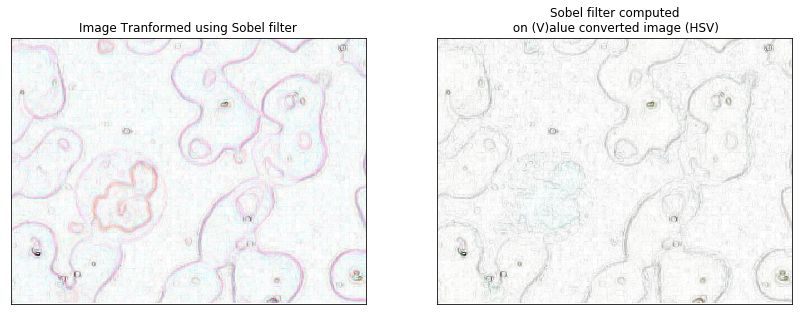

In [17]:
from skimage.exposure import rescale_intensity

fig, (ax_each, ax_hsv) = plt.subplots(ncols=2, figsize=(14, 7))

# We use 1 - sobel_each(image) but this won't work if image is not normalized
ax_each.imshow(rescale_intensity(1 - sobel_each(image)))
ax_each.set_xticks([]), ax_each.set_yticks([])
ax_each.set_title("Image Tranformed using Sobel filter")

# We use 1 - sobel_hsv(image) but this won't work if image is not normalized
ax_hsv.imshow(rescale_intensity(1 - sobel_hsv(image)))
ax_hsv.set_xticks([]), ax_hsv.set_yticks([])
ax_hsv.set_title("Sobel filter computed\n on (V)alue converted image (HSV)")

### Trying out different ways to tranform the image using sobel filter

In [18]:
image = cv2.imread("../Data Science/dataset-master/JPEGImages/BloodImage_00022.jpg")
image = rescale_intensity(sobel_each(image))

### Function to plot an image

In [30]:
def plotImage(image):
    plt.figure(figsize=(14,7))
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.axis('off')

(-0.5, 639.5, 479.5, -0.5)

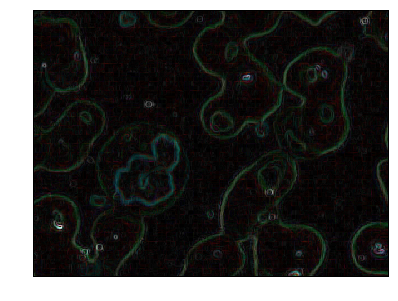

In [19]:
plotImage(image)

In [20]:
image = cv2.imread("../Data Science/dataset-master/JPEGImages/BloodImage_00022.jpg")
image = sobel_each(image)

(-0.5, 639.5, 479.5, -0.5)

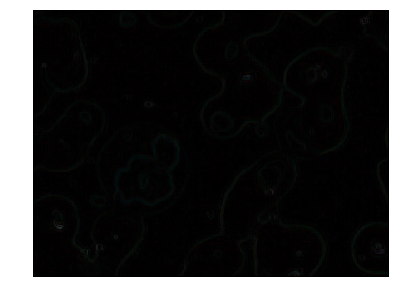

In [21]:
plotImage(image)

In [22]:
image = cv2.imread("../Data Science/dataset-master/JPEGImages/BloodImage_00022.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image = filters.sobel(image)

(-0.5, 639.5, 479.5, -0.5)

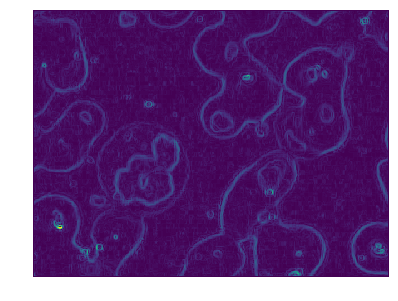

In [23]:
plotImage(image)

## Pre Processing the data using sobel filter

Before resizing the image we are trasforming the image using 1-sobel_each(img_file) filter. This way we can ensure that every image is tranformed.

In [24]:
#Loading the data 
from tqdm import tqdm
#tqdm is to show the progress of detting data from images
def get_data(folder):
    X = []
    y = []
    for wbc_type in os.listdir(folder):
        if not wbc_type.startswith('.'):
            if wbc_type in ['NEUTROPHIL']:
                label = 1

            elif wbc_type in ['EOSINOPHIL']:
                label = 2

            elif wbc_type in ['MONOCYTE']:
                label = 3  

            elif wbc_type in ['LYMPHOCYTE']:
                label = 4 
            else:
                label = 5
            for image_filename in tqdm(os.listdir(folder + wbc_type)):
                img_file = cv2.imread(folder + wbc_type + '/' + image_filename)
                if img_file is not None:
                    img_file = rescale_intensity(1-sobel_each(img_file))
                    img_file = scipy.misc.imresize(arr=img_file, size=(60, 80, 3))
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)

    X = np.asarray(X)
    y = np.asarray(y)
    return X,y
X_train, y_train = get_data('../Data Science/dataset2-master/images/TRAIN/')
X_test, y_test = get_data('../Data Science/dataset2-master/images/TEST/')

# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
from keras.utils.np_utils import to_categorical
y_trainHot = to_categorical(y_train, num_classes = 5)
y_testHot = to_categorical(y_test, num_classes = 5)

print(cell_types)

  0%|                                                                                         | 0/2497 [00:00<?, ?it/s]C:\Users\balak\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:26: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
100%|████████████████████████████████████████████████████████████████████████████████| 624/624 [00:13<00:00, 47.28it/s]


{1: 'NEUTROPHIL', 2: 'EOSINOPHIL', 3: 'MONOCYTE', 4: 'LYMPHOCYTE'}


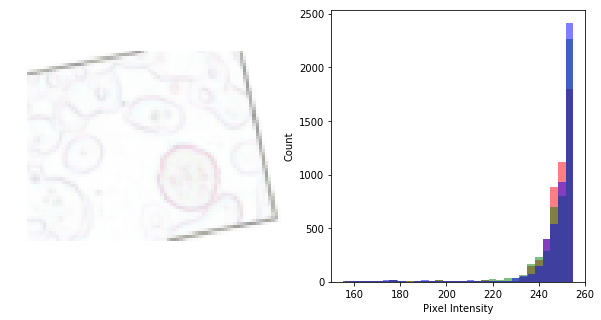

In [25]:
plotHistogram(X_train[1])

In [26]:
X_train=np.array(X_train)
X_train=X_train/255.0

X_test=np.array(X_test)
X_test=X_test/255.0

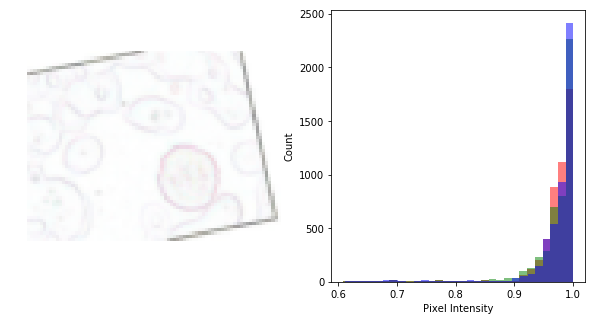

In [27]:
plotHistogram(X_train[1])

## Running CNN on sobel's pre-processed data

We are using the same CNN function that we created before, but we are using the tranformed dataset

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/30
312/311 [==============================] - 299s 959ms/step - loss: 1.4911 - acc: 0.2485 - val_loss: 1.3963 - val_acc: 0.2509
Epoch 2/30
312/311 [==============================] - 304s 974ms/step - loss: 1.4029 - acc: 0.2499 - val_loss: 1.3916 - val_acc: 0.2505
Epoch 3/30
312/311 [==============================] - 303s 971ms/step - loss: 1.3941 - acc: 0.2417 - val_loss: 1.3950 - val_acc: 0.2509
Epoch 4/30
312/311 [==============================] - 305s 976ms/step - loss: 1.3920 - acc: 0.2433 - val_loss: 1.3867 - val_acc: 0.2505
Epoch 5/30
312/311 [==============================] - 305s 978ms/step - loss: 1.3902 - acc: 0.2488 - val_loss: 1.3877 - val_acc: 0.2493
Epoch 6/30
312/311 [==============================] - 306s 980ms/step - loss: 1.3890 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



              precision    recall  f1-score   support

  NEUTROPHIL       0.25      1.00      0.40       624
  EOSINOPHIL       0.00      0.00      0.00       623
    MONOCYTE       0.00      0.00      0.00       620
  LYMPHOCYTE       0.00      0.00      0.00       620

   micro avg       0.25      0.25      0.25      2487
   macro avg       0.06      0.25      0.10      2487
weighted avg       0.06      0.25      0.10      2487



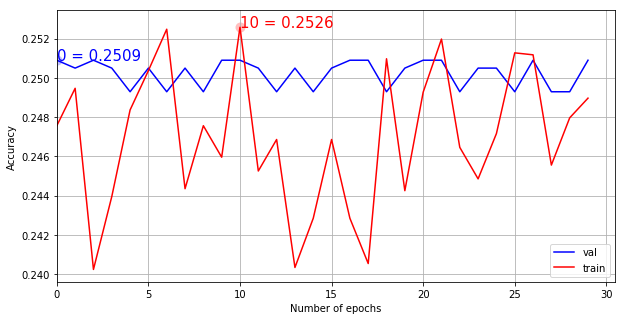

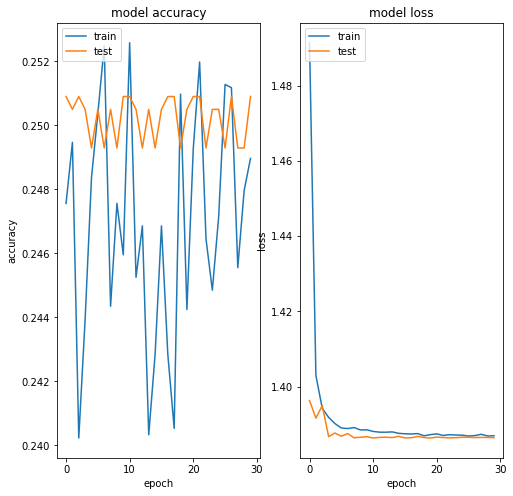

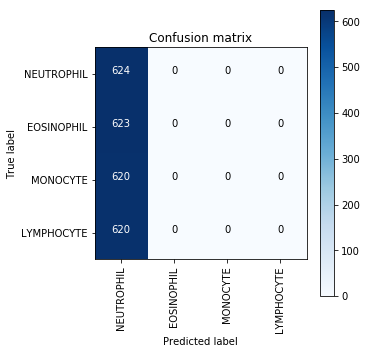

In [19]:
runKerasCNNAugment(X_train,y_trainHot,X_test,y_testHot,1)

### Results

We got a very low accuracy of 25% and the model all the cells as NEUTROPHILS. This might be because when we detected edges of the images, we got the edges of all the other cells(WBCs) in the image. But RBCs are present in all the images. So the model might get thought all the images as same.  

## Getting only white blood cells from the image.

So before using sobel filter on the images, I am just getting the white blood cells from the images by using its color difference from red blood cells on the image.

This I am acheiving by following steps:

1. Using OpenCVs cvtColor() method to convert our image to HSV

2. Then defining the blue color range as wbcs in our image are in blue color

3. Then add these ranges as threshold to the HSv converted image to get only blue colors using OpenCv's inRange methods

4. Then mask the original image with this converted image.

5. That way we get onlt the blue colored parts of the image.

(-0.5, 639.5, 479.5, -0.5)

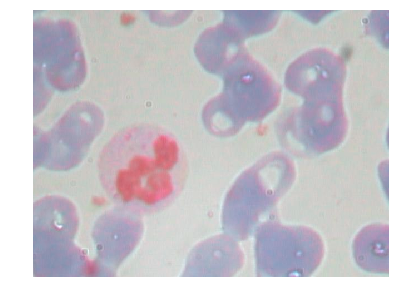

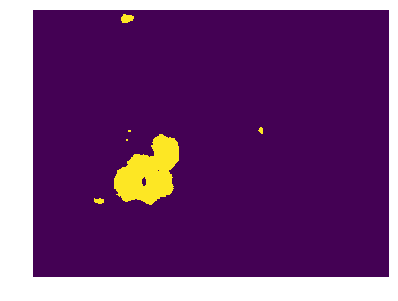

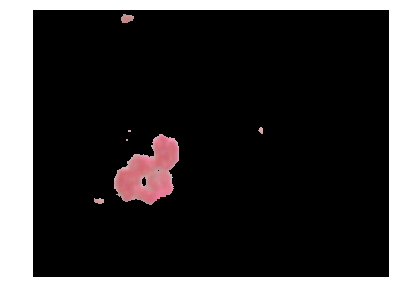

In [28]:
cap = cv2.imread("../Data Science/dataset-master/JPEGImages/BloodImage_00022.jpg")
#Using OpenCVs cvtColor() method to convert out image to HSV
hsv = cv2.cvtColor(cap, cv2.COLOR_BGR2HSV)
# define range of blue color in HSV
lower_blue = np.array([110,50,50])
upper_blue = np.array([130,255,255])

# Threshold the HSV image to get only blue colors
mask = cv2.inRange(hsv, lower_blue, upper_blue)

# Bitwise-AND mask and original image
res = cv2.bitwise_and(cap,cap, mask= mask)

plotImage(cap)

plotImage(mask)

plotImage(res)

## Now apply sobel filter to this converted image

Trying some ways to transform this image using sobvel filter

In [32]:
image = rescale_intensity(sobel_each(res))

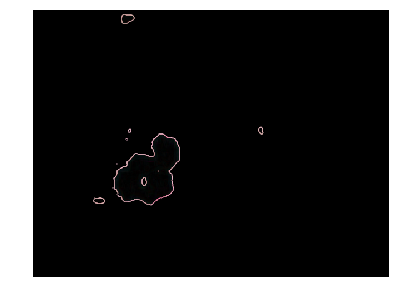

In [33]:
plotImage(image)

In [34]:
image = rescale_intensity(1-sobel_each(res))

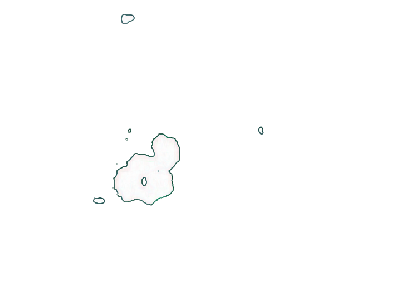

In [35]:
plotImage(image)

In [51]:
image = (sobel_each(res))

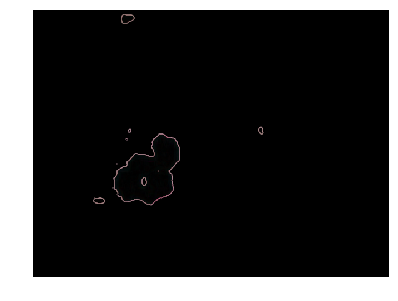

In [52]:
plotImage(image)

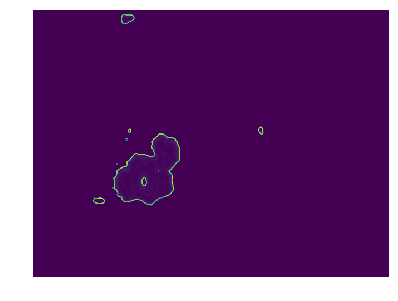

In [56]:
image = cv2.cvtColor(res, cv2.COLOR_BGR2GRAY)
image = filters.sobel(image)
plotImage(image)

### Now pre processing the whole data using the above technique and then using sobel filter.

Modifying the get_data function to do the same.

In [57]:
def get_data(folder):
    X = []
    y = []
    for wbc_type in os.listdir(folder):
        if not wbc_type.startswith('.'):
            if wbc_type in ['NEUTROPHIL']:
                label = 1

            elif wbc_type in ['EOSINOPHIL']:
                label = 2

            elif wbc_type in ['MONOCYTE']:
                label = 3  

            elif wbc_type in ['LYMPHOCYTE']:
                label = 4 
            else:
                label = 5
            for image_filename in tqdm(os.listdir(folder + wbc_type)):
                img_file = cv2.imread(folder + wbc_type + '/' + image_filename)
                if img_file is not None:
                    hsv = cv2.cvtColor(img_file, cv2.COLOR_BGR2HSV)
                    # define range of blue color in HSV
                    lower_blue = np.array([110,50,50])
                    upper_blue = np.array([130,255,255])

                    # Threshold the HSV image to get only blue colors
                    mask = cv2.inRange(hsv, lower_blue, upper_blue)

                    # Bitwise-AND mask and original image
                    res = cv2.bitwise_and(img_file,img_file, mask= mask)
                    res = rescale_intensity(1-sobel_each(res))
                    img_file = scipy.misc.imresize(arr=res, size=(60, 80, 3))
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)
                    
    X = np.asarray(X)
    y = np.asarray(y)

    return X,y

X_train, y_train = get_data('../Data Science/dataset2-master/images/TRAIN/')
X_test, y_test = get_data('../Data Science/dataset2-master/images/TEST/')

# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
from keras.utils.np_utils import to_categorical
y_trainHot = to_categorical(y_train, num_classes = 5)
y_testHot = to_categorical(y_test, num_classes = 5)

print(cell_types)

  0%|                                                                                         | 0/2497 [00:00<?, ?it/s]C:\Users\balak\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:33: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
100%|███████████████████████████████████████████████████████████████████████████████| 624/624 [00:02<00:00, 240.33it/s]


{1: 'NEUTROPHIL', 2: 'EOSINOPHIL', 3: 'MONOCYTE', 4: 'LYMPHOCYTE'}


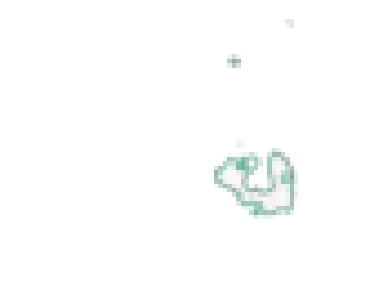

In [39]:
plotImage(X_train[1])

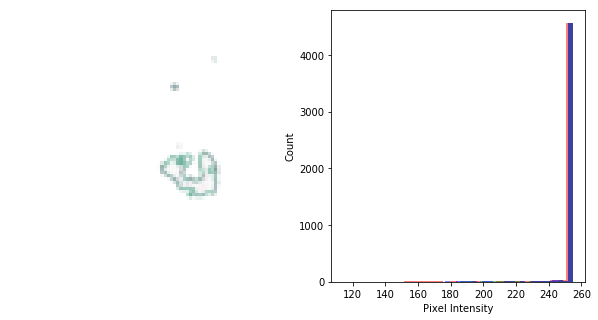

In [40]:
   plotHistogram(X_train[1])

In [41]:
X_train=np.array(X_train)
X_train=X_train/255.0

X_test=np.array(X_test)
X_test=X_test/255.0

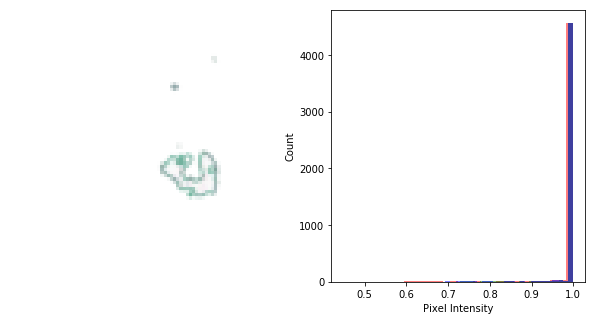

In [42]:
plotHistogram(X_train[1])

## Running CNN on this data

Epoch 1/30


204/311 [==================>...........] - ETA: 11:13 - loss: 8.2690 - acc: 0.18 - ETA: 7:43 - loss: 8.3908 - acc: 0.2812 - ETA: 6:13 - loss: 9.5229 - acc: 0.250 - ETA: 5:30 - loss: 9.1905 - acc: 0.257 - ETA: 5:02 - loss: 9.8021 - acc: 0.250 - ETA: 4:55 - loss: 10.1377 - acc: 0.25 - ETA: 4:49 - loss: 10.2042 - acc: 0.24 - ETA: 4:45 - loss: 10.2853 - acc: 0.23 - ETA: 4:38 - loss: 10.1812 - acc: 0.25 - ETA: 4:30 - loss: 10.3971 - acc: 0.23 - ETA: 4:23 - loss: 10.4521 - acc: 0.23 - ETA: 4:17 - loss: 10.4753 - acc: 0.23 - ETA: 4:13 - loss: 10.4239 - acc: 0.24 - ETA: 4:10 - loss: 10.4177 - acc: 0.24 - ETA: 4:05 - loss: 10.3264 - acc: 0.25 - ETA: 4:03 - loss: 10.4114 - acc: 0.25 - ETA: 3:59 - loss: 10.2319 - acc: 0.26 - ETA: 3:57 - loss: 10.3014 - acc: 0.26 - ETA: 3:54 - loss: 10.1333 - acc: 0.26 - ETA: 3:53 - loss: 10.0649 - acc: 0.27 - ETA: 3:50 - loss: 9.9418 - acc: 0.2768 - ETA: 3:49 - loss: 9.8854 - acc: 0.272 - ETA: 3:47 - loss: 9.8315 - acc: 0.269 - ETA: 3:45 - loss: 9.6552 - acc: 0.2

312/311 [==============================] - ETA: 1:13 - loss: 2.2581 - acc: 0.402 - ETA: 1:12 - loss: 2.2515 - acc: 0.403 - ETA: 1:11 - loss: 2.2483 - acc: 0.404 - ETA: 1:11 - loss: 2.2444 - acc: 0.404 - ETA: 1:10 - loss: 2.2384 - acc: 0.405 - ETA: 1:09 - loss: 2.2327 - acc: 0.406 - ETA: 1:09 - loss: 2.2281 - acc: 0.406 - ETA: 1:08 - loss: 2.2227 - acc: 0.407 - ETA: 1:07 - loss: 2.2166 - acc: 0.408 - ETA: 1:06 - loss: 2.2112 - acc: 0.409 - ETA: 1:06 - loss: 2.2087 - acc: 0.408 - ETA: 1:05 - loss: 2.2051 - acc: 0.407 - ETA: 1:04 - loss: 2.2006 - acc: 0.408 - ETA: 1:04 - loss: 2.1955 - acc: 0.408 - ETA: 1:03 - loss: 2.1904 - acc: 0.409 - ETA: 1:02 - loss: 2.1854 - acc: 0.410 - ETA: 1:02 - loss: 2.1796 - acc: 0.411 - ETA: 1:01 - loss: 2.1740 - acc: 0.412 - ETA: 1:00 - loss: 2.1694 - acc: 0.413 - ETA: 59s - loss: 2.1645 - acc: 0.414 - ETA: 59s - loss: 2.1590 - acc: 0.41 - ETA: 58s - loss: 2.1530 - acc: 0.41 - ETA: 57s - loss: 2.1488 - acc: 0.41 - ETA: 57s - loss: 2.1441 - acc: 0.41 - ETA: 5

204/311 [==================>...........] - ETA: 3:14 - loss: 0.9761 - acc: 0.656 - ETA: 3:17 - loss: 0.9405 - acc: 0.625 - ETA: 3:16 - loss: 0.9594 - acc: 0.614 - ETA: 3:15 - loss: 1.0567 - acc: 0.585 - ETA: 3:14 - loss: 1.0630 - acc: 0.550 - ETA: 3:13 - loss: 1.0063 - acc: 0.572 - ETA: 3:12 - loss: 0.9844 - acc: 0.580 - ETA: 3:11 - loss: 0.9667 - acc: 0.593 - ETA: 3:11 - loss: 0.9605 - acc: 0.607 - ETA: 3:10 - loss: 0.9489 - acc: 0.606 - ETA: 3:09 - loss: 0.9463 - acc: 0.608 - ETA: 3:09 - loss: 0.9438 - acc: 0.601 - ETA: 3:08 - loss: 0.9376 - acc: 0.610 - ETA: 3:07 - loss: 0.9446 - acc: 0.609 - ETA: 3:07 - loss: 0.9430 - acc: 0.610 - ETA: 3:07 - loss: 0.9465 - acc: 0.607 - ETA: 3:07 - loss: 0.9525 - acc: 0.604 - ETA: 3:07 - loss: 0.9569 - acc: 0.600 - ETA: 3:08 - loss: 0.9864 - acc: 0.593 - ETA: 3:08 - loss: 1.0137 - acc: 0.573 - ETA: 3:08 - loss: 1.0070 - acc: 0.578 - ETA: 3:08 - loss: 0.9966 - acc: 0.583 - ETA: 3:08 - loss: 0.9875 - acc: 0.584 - ETA: 3:08 - loss: 0.9726 - acc: 0.593

312/311 [==============================] - ETA: 1:13 - loss: 0.9668 - acc: 0.598 - ETA: 1:12 - loss: 0.9666 - acc: 0.598 - ETA: 1:12 - loss: 0.9667 - acc: 0.598 - ETA: 1:11 - loss: 0.9679 - acc: 0.598 - ETA: 1:10 - loss: 0.9676 - acc: 0.597 - ETA: 1:10 - loss: 0.9682 - acc: 0.597 - ETA: 1:09 - loss: 0.9691 - acc: 0.597 - ETA: 1:08 - loss: 0.9687 - acc: 0.597 - ETA: 1:07 - loss: 0.9685 - acc: 0.596 - ETA: 1:07 - loss: 0.9681 - acc: 0.597 - ETA: 1:06 - loss: 0.9677 - acc: 0.596 - ETA: 1:05 - loss: 0.9672 - acc: 0.596 - ETA: 1:05 - loss: 0.9670 - acc: 0.596 - ETA: 1:04 - loss: 0.9672 - acc: 0.597 - ETA: 1:03 - loss: 0.9664 - acc: 0.597 - ETA: 1:02 - loss: 0.9664 - acc: 0.597 - ETA: 1:02 - loss: 0.9668 - acc: 0.597 - ETA: 1:01 - loss: 0.9666 - acc: 0.597 - ETA: 1:00 - loss: 0.9664 - acc: 0.597 - ETA: 1:00 - loss: 0.9662 - acc: 0.597 - ETA: 59s - loss: 0.9672 - acc: 0.597 - ETA: 58s - loss: 0.9668 - acc: 0.59 - ETA: 57s - loss: 0.9655 - acc: 0.59 - ETA: 57s - loss: 0.9650 - acc: 0.59 - ETA:

204/311 [==================>...........] - ETA: 3:25 - loss: 0.9627 - acc: 0.468 - ETA: 3:24 - loss: 0.9670 - acc: 0.531 - ETA: 3:22 - loss: 1.0056 - acc: 0.541 - ETA: 3:20 - loss: 0.9968 - acc: 0.531 - ETA: 3:19 - loss: 0.9509 - acc: 0.550 - ETA: 3:18 - loss: 0.9495 - acc: 0.572 - ETA: 3:17 - loss: 0.9418 - acc: 0.571 - ETA: 3:16 - loss: 0.9192 - acc: 0.574 - ETA: 3:15 - loss: 0.9120 - acc: 0.576 - ETA: 3:14 - loss: 0.8938 - acc: 0.584 - ETA: 3:14 - loss: 0.8943 - acc: 0.576 - ETA: 3:13 - loss: 0.8722 - acc: 0.593 - ETA: 3:12 - loss: 0.8664 - acc: 0.598 - ETA: 3:11 - loss: 0.8558 - acc: 0.607 - ETA: 3:11 - loss: 0.8413 - acc: 0.614 - ETA: 3:10 - loss: 0.8616 - acc: 0.609 - ETA: 3:10 - loss: 0.8670 - acc: 0.610 - ETA: 3:09 - loss: 0.8953 - acc: 0.607 - ETA: 3:08 - loss: 0.8948 - acc: 0.605 - ETA: 3:07 - loss: 0.9037 - acc: 0.601 - ETA: 3:06 - loss: 0.9158 - acc: 0.589 - ETA: 3:06 - loss: 0.9407 - acc: 0.585 - ETA: 3:05 - loss: 0.9464 - acc: 0.576 - ETA: 3:04 - loss: 0.9465 - acc: 0.576

312/311 [==============================] - ETA: 1:06 - loss: 0.8846 - acc: 0.628 - ETA: 1:06 - loss: 0.8849 - acc: 0.628 - ETA: 1:05 - loss: 0.8843 - acc: 0.628 - ETA: 1:04 - loss: 0.8846 - acc: 0.627 - ETA: 1:04 - loss: 0.8840 - acc: 0.627 - ETA: 1:03 - loss: 0.8838 - acc: 0.627 - ETA: 1:02 - loss: 0.8846 - acc: 0.627 - ETA: 1:02 - loss: 0.8844 - acc: 0.627 - ETA: 1:01 - loss: 0.8838 - acc: 0.627 - ETA: 1:01 - loss: 0.8842 - acc: 0.627 - ETA: 1:00 - loss: 0.8843 - acc: 0.626 - ETA: 59s - loss: 0.8841 - acc: 0.626 - ETA: 59s - loss: 0.8849 - acc: 0.62 - ETA: 58s - loss: 0.8855 - acc: 0.62 - ETA: 57s - loss: 0.8858 - acc: 0.62 - ETA: 57s - loss: 0.8848 - acc: 0.62 - ETA: 56s - loss: 0.8843 - acc: 0.62 - ETA: 55s - loss: 0.8831 - acc: 0.62 - ETA: 55s - loss: 0.8825 - acc: 0.62 - ETA: 54s - loss: 0.8817 - acc: 0.62 - ETA: 54s - loss: 0.8817 - acc: 0.62 - ETA: 53s - loss: 0.8816 - acc: 0.62 - ETA: 52s - loss: 0.8807 - acc: 0.62 - ETA: 52s - loss: 0.8798 - acc: 0.62 - ETA: 51s - loss: 0.879

204/311 [==================>...........] - ETA: 3:27 - loss: 1.3301 - acc: 0.500 - ETA: 3:32 - loss: 1.1682 - acc: 0.531 - ETA: 3:34 - loss: 1.0091 - acc: 0.593 - ETA: 3:30 - loss: 0.9014 - acc: 0.648 - ETA: 3:30 - loss: 0.8956 - acc: 0.643 - ETA: 3:27 - loss: 0.9070 - acc: 0.645 - ETA: 3:25 - loss: 0.8688 - acc: 0.669 - ETA: 3:23 - loss: 0.8556 - acc: 0.671 - ETA: 3:26 - loss: 0.8158 - acc: 0.687 - ETA: 3:26 - loss: 0.8200 - acc: 0.681 - ETA: 3:25 - loss: 0.8171 - acc: 0.673 - ETA: 3:23 - loss: 0.7973 - acc: 0.671 - ETA: 3:28 - loss: 0.7796 - acc: 0.677 - ETA: 3:28 - loss: 0.8110 - acc: 0.669 - ETA: 3:29 - loss: 0.8242 - acc: 0.660 - ETA: 3:28 - loss: 0.8330 - acc: 0.660 - ETA: 3:28 - loss: 0.8275 - acc: 0.656 - ETA: 3:26 - loss: 0.8243 - acc: 0.654 - ETA: 3:23 - loss: 0.8265 - acc: 0.648 - ETA: 3:21 - loss: 0.8128 - acc: 0.654 - ETA: 3:21 - loss: 0.8269 - acc: 0.657 - ETA: 3:19 - loss: 0.8401 - acc: 0.647 - ETA: 3:18 - loss: 0.8549 - acc: 0.639 - ETA: 3:16 - loss: 0.8615 - acc: 0.638

312/311 [==============================] - ETA: 1:08 - loss: 0.8031 - acc: 0.666 - ETA: 1:07 - loss: 0.8021 - acc: 0.667 - ETA: 1:06 - loss: 0.8007 - acc: 0.667 - ETA: 1:06 - loss: 0.7998 - acc: 0.667 - ETA: 1:05 - loss: 0.8004 - acc: 0.666 - ETA: 1:04 - loss: 0.8006 - acc: 0.667 - ETA: 1:04 - loss: 0.8022 - acc: 0.666 - ETA: 1:03 - loss: 0.8024 - acc: 0.666 - ETA: 1:02 - loss: 0.8020 - acc: 0.666 - ETA: 1:02 - loss: 0.8015 - acc: 0.666 - ETA: 1:01 - loss: 0.8006 - acc: 0.666 - ETA: 1:00 - loss: 0.8011 - acc: 0.667 - ETA: 1:00 - loss: 0.8004 - acc: 0.667 - ETA: 59s - loss: 0.8001 - acc: 0.667 - ETA: 58s - loss: 0.8001 - acc: 0.66 - ETA: 58s - loss: 0.8003 - acc: 0.66 - ETA: 57s - loss: 0.8006 - acc: 0.66 - ETA: 57s - loss: 0.8013 - acc: 0.66 - ETA: 56s - loss: 0.8010 - acc: 0.66 - ETA: 55s - loss: 0.8010 - acc: 0.66 - ETA: 55s - loss: 0.8006 - acc: 0.66 - ETA: 54s - loss: 0.8013 - acc: 0.66 - ETA: 53s - loss: 0.8013 - acc: 0.66 - ETA: 53s - loss: 0.8003 - acc: 0.66 - ETA: 52s - loss: 0

204/311 [==================>...........] - ETA: 3:08 - loss: 0.8041 - acc: 0.750 - ETA: 3:09 - loss: 0.7023 - acc: 0.796 - ETA: 3:11 - loss: 0.7962 - acc: 0.739 - ETA: 3:10 - loss: 0.7967 - acc: 0.726 - ETA: 3:08 - loss: 0.7525 - acc: 0.743 - ETA: 3:08 - loss: 0.7413 - acc: 0.739 - ETA: 3:07 - loss: 0.7900 - acc: 0.723 - ETA: 3:06 - loss: 0.7851 - acc: 0.718 - ETA: 3:05 - loss: 0.7770 - acc: 0.715 - ETA: 3:04 - loss: 0.7474 - acc: 0.725 - ETA: 3:04 - loss: 0.7299 - acc: 0.730 - ETA: 3:03 - loss: 0.7453 - acc: 0.713 - ETA: 3:02 - loss: 0.7353 - acc: 0.716 - ETA: 3:02 - loss: 0.7564 - acc: 0.705 - ETA: 3:01 - loss: 0.7657 - acc: 0.700 - ETA: 3:00 - loss: 0.7639 - acc: 0.695 - ETA: 3:00 - loss: 0.7724 - acc: 0.685 - ETA: 2:59 - loss: 0.7725 - acc: 0.685 - ETA: 2:59 - loss: 0.7778 - acc: 0.684 - ETA: 2:59 - loss: 0.7895 - acc: 0.685 - ETA: 2:59 - loss: 0.7899 - acc: 0.686 - ETA: 2:59 - loss: 0.7915 - acc: 0.687 - ETA: 2:59 - loss: 0.7889 - acc: 0.691 - ETA: 2:58 - loss: 0.8023 - acc: 0.683

312/311 [==============================] - ETA: 1:07 - loss: 0.7471 - acc: 0.683 - ETA: 1:06 - loss: 0.7469 - acc: 0.683 - ETA: 1:05 - loss: 0.7468 - acc: 0.683 - ETA: 1:05 - loss: 0.7492 - acc: 0.683 - ETA: 1:04 - loss: 0.7508 - acc: 0.683 - ETA: 1:03 - loss: 0.7507 - acc: 0.682 - ETA: 1:03 - loss: 0.7502 - acc: 0.682 - ETA: 1:02 - loss: 0.7501 - acc: 0.682 - ETA: 1:01 - loss: 0.7496 - acc: 0.683 - ETA: 1:01 - loss: 0.7506 - acc: 0.682 - ETA: 1:00 - loss: 0.7508 - acc: 0.682 - ETA: 1:00 - loss: 0.7501 - acc: 0.682 - ETA: 59s - loss: 0.7492 - acc: 0.683 - ETA: 58s - loss: 0.7494 - acc: 0.68 - ETA: 58s - loss: 0.7487 - acc: 0.68 - ETA: 57s - loss: 0.7482 - acc: 0.68 - ETA: 56s - loss: 0.7480 - acc: 0.68 - ETA: 56s - loss: 0.7477 - acc: 0.68 - ETA: 55s - loss: 0.7478 - acc: 0.68 - ETA: 54s - loss: 0.7474 - acc: 0.68 - ETA: 54s - loss: 0.7486 - acc: 0.68 - ETA: 53s - loss: 0.7493 - acc: 0.68 - ETA: 53s - loss: 0.7498 - acc: 0.68 - ETA: 52s - loss: 0.7497 - acc: 0.68 - ETA: 51s - loss: 0.7

204/311 [==================>...........] - ETA: 3:14 - loss: 0.7873 - acc: 0.687 - ETA: 3:15 - loss: 0.7582 - acc: 0.687 - ETA: 3:14 - loss: 0.6656 - acc: 0.760 - ETA: 3:12 - loss: 0.6826 - acc: 0.718 - ETA: 3:10 - loss: 0.6469 - acc: 0.743 - ETA: 3:09 - loss: 0.6713 - acc: 0.729 - ETA: 3:09 - loss: 0.6469 - acc: 0.736 - ETA: 3:08 - loss: 0.6775 - acc: 0.718 - ETA: 3:08 - loss: 0.6788 - acc: 0.715 - ETA: 3:07 - loss: 0.6743 - acc: 0.718 - ETA: 3:06 - loss: 0.6632 - acc: 0.724 - ETA: 3:05 - loss: 0.6740 - acc: 0.713 - ETA: 3:05 - loss: 0.6878 - acc: 0.711 - ETA: 3:04 - loss: 0.6898 - acc: 0.707 - ETA: 3:04 - loss: 0.6847 - acc: 0.706 - ETA: 3:03 - loss: 0.6917 - acc: 0.709 - ETA: 3:03 - loss: 0.6922 - acc: 0.704 - ETA: 3:02 - loss: 0.6878 - acc: 0.708 - ETA: 3:01 - loss: 0.6752 - acc: 0.710 - ETA: 3:00 - loss: 0.6698 - acc: 0.712 - ETA: 2:59 - loss: 0.6764 - acc: 0.708 - ETA: 2:59 - loss: 0.6799 - acc: 0.706 - ETA: 2:58 - loss: 0.6813 - acc: 0.701 - ETA: 2:57 - loss: 0.6825 - acc: 0.700

312/311 [==============================] - ETA: 1:05 - loss: 0.7416 - acc: 0.682 - ETA: 1:05 - loss: 0.7431 - acc: 0.681 - ETA: 1:04 - loss: 0.7444 - acc: 0.681 - ETA: 1:04 - loss: 0.7449 - acc: 0.681 - ETA: 1:03 - loss: 0.7457 - acc: 0.680 - ETA: 1:02 - loss: 0.7458 - acc: 0.680 - ETA: 1:02 - loss: 0.7463 - acc: 0.679 - ETA: 1:01 - loss: 0.7464 - acc: 0.679 - ETA: 1:00 - loss: 0.7462 - acc: 0.679 - ETA: 1:00 - loss: 0.7462 - acc: 0.679 - ETA: 59s - loss: 0.7481 - acc: 0.678 - ETA: 59s - loss: 0.7486 - acc: 0.67 - ETA: 58s - loss: 0.7487 - acc: 0.67 - ETA: 57s - loss: 0.7492 - acc: 0.67 - ETA: 57s - loss: 0.7494 - acc: 0.67 - ETA: 56s - loss: 0.7504 - acc: 0.67 - ETA: 55s - loss: 0.7502 - acc: 0.67 - ETA: 55s - loss: 0.7493 - acc: 0.67 - ETA: 54s - loss: 0.7484 - acc: 0.67 - ETA: 54s - loss: 0.7480 - acc: 0.67 - ETA: 53s - loss: 0.7480 - acc: 0.67 - ETA: 52s - loss: 0.7480 - acc: 0.67 - ETA: 52s - loss: 0.7491 - acc: 0.67 - ETA: 51s - loss: 0.7487 - acc: 0.67 - ETA: 50s - loss: 0.7489 

204/311 [==================>...........] - ETA: 3:12 - loss: 0.7347 - acc: 0.593 - ETA: 3:11 - loss: 0.7825 - acc: 0.609 - ETA: 3:11 - loss: 0.7204 - acc: 0.656 - ETA: 3:11 - loss: 0.6870 - acc: 0.671 - ETA: 3:10 - loss: 0.6574 - acc: 0.687 - ETA: 3:09 - loss: 0.7106 - acc: 0.687 - ETA: 3:08 - loss: 0.7280 - acc: 0.687 - ETA: 3:08 - loss: 0.7329 - acc: 0.683 - ETA: 3:08 - loss: 0.7260 - acc: 0.680 - ETA: 3:08 - loss: 0.7235 - acc: 0.678 - ETA: 3:06 - loss: 0.7465 - acc: 0.676 - ETA: 3:05 - loss: 0.7679 - acc: 0.666 - ETA: 3:05 - loss: 0.7591 - acc: 0.673 - ETA: 3:04 - loss: 0.7619 - acc: 0.678 - ETA: 3:03 - loss: 0.7556 - acc: 0.677 - ETA: 3:02 - loss: 0.7527 - acc: 0.681 - ETA: 3:02 - loss: 0.7428 - acc: 0.691 - ETA: 3:01 - loss: 0.7414 - acc: 0.691 - ETA: 3:00 - loss: 0.7348 - acc: 0.690 - ETA: 3:00 - loss: 0.7368 - acc: 0.692 - ETA: 2:59 - loss: 0.7325 - acc: 0.690 - ETA: 2:59 - loss: 0.7300 - acc: 0.694 - ETA: 2:59 - loss: 0.7254 - acc: 0.697 - ETA: 2:58 - loss: 0.7292 - acc: 0.692

312/311 [==============================] - ETA: 1:04 - loss: 0.7147 - acc: 0.693 - ETA: 1:04 - loss: 0.7163 - acc: 0.693 - ETA: 1:03 - loss: 0.7155 - acc: 0.693 - ETA: 1:03 - loss: 0.7159 - acc: 0.693 - ETA: 1:02 - loss: 0.7152 - acc: 0.693 - ETA: 1:01 - loss: 0.7145 - acc: 0.694 - ETA: 1:01 - loss: 0.7136 - acc: 0.694 - ETA: 1:00 - loss: 0.7136 - acc: 0.694 - ETA: 59s - loss: 0.7138 - acc: 0.694 - ETA: 59s - loss: 0.7128 - acc: 0.69 - ETA: 58s - loss: 0.7116 - acc: 0.69 - ETA: 58s - loss: 0.7113 - acc: 0.69 - ETA: 57s - loss: 0.7113 - acc: 0.69 - ETA: 56s - loss: 0.7131 - acc: 0.69 - ETA: 56s - loss: 0.7152 - acc: 0.69 - ETA: 55s - loss: 0.7153 - acc: 0.69 - ETA: 55s - loss: 0.7143 - acc: 0.69 - ETA: 54s - loss: 0.7130 - acc: 0.69 - ETA: 53s - loss: 0.7142 - acc: 0.69 - ETA: 53s - loss: 0.7134 - acc: 0.69 - ETA: 52s - loss: 0.7140 - acc: 0.69 - ETA: 52s - loss: 0.7133 - acc: 0.69 - ETA: 51s - loss: 0.7144 - acc: 0.69 - ETA: 50s - loss: 0.7149 - acc: 0.69 - ETA: 50s - loss: 0.7150 - ac

204/311 [==================>...........] - ETA: 3:12 - loss: 1.0335 - acc: 0.625 - ETA: 3:13 - loss: 0.9336 - acc: 0.625 - ETA: 3:13 - loss: 0.8716 - acc: 0.666 - ETA: 3:13 - loss: 0.8026 - acc: 0.687 - ETA: 3:11 - loss: 0.8655 - acc: 0.675 - ETA: 3:10 - loss: 0.8425 - acc: 0.677 - ETA: 3:08 - loss: 0.8146 - acc: 0.678 - ETA: 3:07 - loss: 0.8000 - acc: 0.675 - ETA: 3:06 - loss: 0.7748 - acc: 0.687 - ETA: 3:05 - loss: 0.7615 - acc: 0.693 - ETA: 3:04 - loss: 0.7724 - acc: 0.693 - ETA: 3:03 - loss: 0.7873 - acc: 0.695 - ETA: 3:02 - loss: 0.7821 - acc: 0.706 - ETA: 3:02 - loss: 0.7768 - acc: 0.707 - ETA: 3:01 - loss: 0.7760 - acc: 0.706 - ETA: 3:00 - loss: 0.7770 - acc: 0.699 - ETA: 3:00 - loss: 0.7627 - acc: 0.704 - ETA: 2:59 - loss: 0.7461 - acc: 0.711 - ETA: 2:58 - loss: 0.7418 - acc: 0.715 - ETA: 2:57 - loss: 0.7406 - acc: 0.712 - ETA: 2:57 - loss: 0.7518 - acc: 0.709 - ETA: 2:56 - loss: 0.7468 - acc: 0.711 - ETA: 2:56 - loss: 0.7393 - acc: 0.710 - ETA: 2:56 - loss: 0.7346 - acc: 0.713

312/311 [==============================] - ETA: 1:06 - loss: 0.6905 - acc: 0.708 - ETA: 1:05 - loss: 0.6898 - acc: 0.709 - ETA: 1:04 - loss: 0.6893 - acc: 0.709 - ETA: 1:04 - loss: 0.6893 - acc: 0.709 - ETA: 1:03 - loss: 0.6883 - acc: 0.709 - ETA: 1:03 - loss: 0.6891 - acc: 0.709 - ETA: 1:02 - loss: 0.6897 - acc: 0.708 - ETA: 1:01 - loss: 0.6892 - acc: 0.708 - ETA: 1:01 - loss: 0.6898 - acc: 0.708 - ETA: 1:00 - loss: 0.6897 - acc: 0.708 - ETA: 59s - loss: 0.6893 - acc: 0.708 - ETA: 59s - loss: 0.6894 - acc: 0.70 - ETA: 58s - loss: 0.6887 - acc: 0.70 - ETA: 58s - loss: 0.6881 - acc: 0.70 - ETA: 57s - loss: 0.6881 - acc: 0.70 - ETA: 56s - loss: 0.6885 - acc: 0.70 - ETA: 56s - loss: 0.6899 - acc: 0.70 - ETA: 55s - loss: 0.6897 - acc: 0.70 - ETA: 54s - loss: 0.6896 - acc: 0.70 - ETA: 54s - loss: 0.6895 - acc: 0.70 - ETA: 53s - loss: 0.6891 - acc: 0.70 - ETA: 53s - loss: 0.6894 - acc: 0.70 - ETA: 52s - loss: 0.6895 - acc: 0.70 - ETA: 51s - loss: 0.6906 - acc: 0.70 - ETA: 51s - loss: 0.6915 

204/311 [==================>...........] - ETA: 3:12 - loss: 0.7755 - acc: 0.593 - ETA: 3:11 - loss: 0.6950 - acc: 0.671 - ETA: 3:12 - loss: 0.6760 - acc: 0.708 - ETA: 3:10 - loss: 0.6473 - acc: 0.726 - ETA: 3:09 - loss: 0.6297 - acc: 0.731 - ETA: 3:08 - loss: 0.6491 - acc: 0.697 - ETA: 3:08 - loss: 0.6751 - acc: 0.687 - ETA: 3:07 - loss: 0.6794 - acc: 0.695 - ETA: 3:07 - loss: 0.6636 - acc: 0.691 - ETA: 3:07 - loss: 0.6716 - acc: 0.687 - ETA: 3:06 - loss: 0.6819 - acc: 0.687 - ETA: 3:06 - loss: 0.6696 - acc: 0.684 - ETA: 3:05 - loss: 0.6765 - acc: 0.687 - ETA: 3:04 - loss: 0.6660 - acc: 0.696 - ETA: 3:04 - loss: 0.6714 - acc: 0.695 - ETA: 3:03 - loss: 0.6838 - acc: 0.697 - ETA: 3:02 - loss: 0.6827 - acc: 0.694 - ETA: 3:02 - loss: 0.6854 - acc: 0.694 - ETA: 3:01 - loss: 0.6771 - acc: 0.697 - ETA: 3:01 - loss: 0.6688 - acc: 0.703 - ETA: 3:00 - loss: 0.6687 - acc: 0.705 - ETA: 2:59 - loss: 0.6652 - acc: 0.711 - ETA: 2:59 - loss: 0.6666 - acc: 0.716 - ETA: 2:58 - loss: 0.6614 - acc: 0.714

312/311 [==============================] - ETA: 1:05 - loss: 0.6835 - acc: 0.698 - ETA: 1:05 - loss: 0.6832 - acc: 0.698 - ETA: 1:04 - loss: 0.6820 - acc: 0.699 - ETA: 1:03 - loss: 0.6817 - acc: 0.698 - ETA: 1:03 - loss: 0.6816 - acc: 0.699 - ETA: 1:02 - loss: 0.6808 - acc: 0.699 - ETA: 1:02 - loss: 0.6816 - acc: 0.699 - ETA: 1:01 - loss: 0.6818 - acc: 0.699 - ETA: 1:00 - loss: 0.6807 - acc: 0.699 - ETA: 1:00 - loss: 0.6814 - acc: 0.699 - ETA: 59s - loss: 0.6807 - acc: 0.699 - ETA: 58s - loss: 0.6820 - acc: 0.69 - ETA: 58s - loss: 0.6821 - acc: 0.69 - ETA: 57s - loss: 0.6817 - acc: 0.69 - ETA: 57s - loss: 0.6813 - acc: 0.69 - ETA: 56s - loss: 0.6814 - acc: 0.70 - ETA: 55s - loss: 0.6810 - acc: 0.70 - ETA: 55s - loss: 0.6798 - acc: 0.70 - ETA: 54s - loss: 0.6809 - acc: 0.70 - ETA: 53s - loss: 0.6812 - acc: 0.70 - ETA: 53s - loss: 0.6809 - acc: 0.70 - ETA: 52s - loss: 0.6804 - acc: 0.70 - ETA: 52s - loss: 0.6802 - acc: 0.70 - ETA: 51s - loss: 0.6801 - acc: 0.70 - ETA: 50s - loss: 0.6805 

204/311 [==================>...........] - ETA: 3:14 - loss: 0.6449 - acc: 0.625 - ETA: 3:21 - loss: 0.5873 - acc: 0.687 - ETA: 3:19 - loss: 0.5307 - acc: 0.739 - ETA: 3:20 - loss: 0.5938 - acc: 0.726 - ETA: 3:19 - loss: 0.6284 - acc: 0.718 - ETA: 3:16 - loss: 0.6512 - acc: 0.718 - ETA: 3:13 - loss: 0.6691 - acc: 0.709 - ETA: 3:12 - loss: 0.6922 - acc: 0.707 - ETA: 3:10 - loss: 0.6975 - acc: 0.694 - ETA: 3:09 - loss: 0.6867 - acc: 0.690 - ETA: 3:08 - loss: 0.6710 - acc: 0.698 - ETA: 3:07 - loss: 0.6590 - acc: 0.705 - ETA: 3:06 - loss: 0.6495 - acc: 0.709 - ETA: 3:05 - loss: 0.6338 - acc: 0.718 - ETA: 3:04 - loss: 0.6520 - acc: 0.718 - ETA: 3:03 - loss: 0.6478 - acc: 0.716 - ETA: 3:02 - loss: 0.6634 - acc: 0.709 - ETA: 3:01 - loss: 0.6634 - acc: 0.706 - ETA: 3:00 - loss: 0.6539 - acc: 0.710 - ETA: 3:00 - loss: 0.6494 - acc: 0.712 - ETA: 2:59 - loss: 0.6542 - acc: 0.711 - ETA: 2:58 - loss: 0.6595 - acc: 0.706 - ETA: 2:57 - loss: 0.6561 - acc: 0.707 - ETA: 2:57 - loss: 0.6560 - acc: 0.705

312/311 [==============================] - ETA: 1:04 - loss: 0.6862 - acc: 0.702 - ETA: 1:04 - loss: 0.6864 - acc: 0.701 - ETA: 1:03 - loss: 0.6853 - acc: 0.702 - ETA: 1:02 - loss: 0.6859 - acc: 0.701 - ETA: 1:02 - loss: 0.6868 - acc: 0.701 - ETA: 1:01 - loss: 0.6868 - acc: 0.701 - ETA: 1:01 - loss: 0.6874 - acc: 0.701 - ETA: 1:00 - loss: 0.6877 - acc: 0.701 - ETA: 59s - loss: 0.6871 - acc: 0.702 - ETA: 59s - loss: 0.6868 - acc: 0.70 - ETA: 58s - loss: 0.6868 - acc: 0.70 - ETA: 58s - loss: 0.6857 - acc: 0.70 - ETA: 57s - loss: 0.6852 - acc: 0.70 - ETA: 56s - loss: 0.6857 - acc: 0.70 - ETA: 56s - loss: 0.6852 - acc: 0.70 - ETA: 55s - loss: 0.6851 - acc: 0.70 - ETA: 55s - loss: 0.6851 - acc: 0.70 - ETA: 54s - loss: 0.6875 - acc: 0.70 - ETA: 53s - loss: 0.6872 - acc: 0.70 - ETA: 53s - loss: 0.6878 - acc: 0.70 - ETA: 52s - loss: 0.6879 - acc: 0.70 - ETA: 51s - loss: 0.6864 - acc: 0.70 - ETA: 51s - loss: 0.6854 - acc: 0.70 - ETA: 50s - loss: 0.6865 - acc: 0.70 - ETA: 50s - loss: 0.6879 - ac

204/311 [==================>...........] - ETA: 3:24 - loss: 0.6186 - acc: 0.781 - ETA: 3:22 - loss: 0.6261 - acc: 0.750 - ETA: 3:17 - loss: 0.6277 - acc: 0.739 - ETA: 3:21 - loss: 0.7071 - acc: 0.734 - ETA: 3:20 - loss: 0.8047 - acc: 0.687 - ETA: 3:21 - loss: 0.7976 - acc: 0.682 - ETA: 3:19 - loss: 0.7702 - acc: 0.700 - ETA: 3:17 - loss: 0.7519 - acc: 0.707 - ETA: 3:16 - loss: 0.7408 - acc: 0.704 - ETA: 3:14 - loss: 0.7385 - acc: 0.715 - ETA: 3:12 - loss: 0.7266 - acc: 0.710 - ETA: 3:11 - loss: 0.7206 - acc: 0.716 - ETA: 3:10 - loss: 0.7053 - acc: 0.718 - ETA: 3:08 - loss: 0.6957 - acc: 0.718 - ETA: 3:07 - loss: 0.7164 - acc: 0.710 - ETA: 3:06 - loss: 0.7212 - acc: 0.707 - ETA: 3:05 - loss: 0.7367 - acc: 0.702 - ETA: 3:04 - loss: 0.7360 - acc: 0.701 - ETA: 3:03 - loss: 0.7353 - acc: 0.699 - ETA: 3:02 - loss: 0.7365 - acc: 0.700 - ETA: 3:01 - loss: 0.7235 - acc: 0.705 - ETA: 3:00 - loss: 0.7292 - acc: 0.701 - ETA: 2:59 - loss: 0.7161 - acc: 0.707 - ETA: 2:58 - loss: 0.7135 - acc: 0.707

312/311 [==============================] - ETA: 1:05 - loss: 0.6770 - acc: 0.707 - ETA: 1:04 - loss: 0.6762 - acc: 0.707 - ETA: 1:03 - loss: 0.6755 - acc: 0.708 - ETA: 1:03 - loss: 0.6755 - acc: 0.708 - ETA: 1:02 - loss: 0.6757 - acc: 0.708 - ETA: 1:02 - loss: 0.6774 - acc: 0.708 - ETA: 1:01 - loss: 0.6800 - acc: 0.707 - ETA: 1:00 - loss: 0.6805 - acc: 0.707 - ETA: 1:00 - loss: 0.6796 - acc: 0.708 - ETA: 59s - loss: 0.6792 - acc: 0.707 - ETA: 58s - loss: 0.6784 - acc: 0.70 - ETA: 58s - loss: 0.6772 - acc: 0.70 - ETA: 57s - loss: 0.6765 - acc: 0.70 - ETA: 57s - loss: 0.6759 - acc: 0.70 - ETA: 56s - loss: 0.6762 - acc: 0.70 - ETA: 55s - loss: 0.6763 - acc: 0.70 - ETA: 55s - loss: 0.6761 - acc: 0.70 - ETA: 54s - loss: 0.6773 - acc: 0.70 - ETA: 54s - loss: 0.6770 - acc: 0.70 - ETA: 53s - loss: 0.6762 - acc: 0.70 - ETA: 52s - loss: 0.6753 - acc: 0.70 - ETA: 52s - loss: 0.6763 - acc: 0.70 - ETA: 51s - loss: 0.6754 - acc: 0.70 - ETA: 50s - loss: 0.6750 - acc: 0.70 - ETA: 50s - loss: 0.6745 - 

204/311 [==================>...........] - ETA: 3:07 - loss: 0.7126 - acc: 0.656 - ETA: 3:09 - loss: 0.7178 - acc: 0.703 - ETA: 3:07 - loss: 0.6238 - acc: 0.729 - ETA: 3:08 - loss: 0.6753 - acc: 0.734 - ETA: 3:07 - loss: 0.6583 - acc: 0.737 - ETA: 3:06 - loss: 0.6880 - acc: 0.718 - ETA: 3:06 - loss: 0.6960 - acc: 0.705 - ETA: 3:06 - loss: 0.6807 - acc: 0.710 - ETA: 3:05 - loss: 0.6552 - acc: 0.718 - ETA: 3:05 - loss: 0.6492 - acc: 0.718 - ETA: 3:04 - loss: 0.6440 - acc: 0.715 - ETA: 3:03 - loss: 0.6528 - acc: 0.716 - ETA: 3:03 - loss: 0.6585 - acc: 0.711 - ETA: 3:02 - loss: 0.6714 - acc: 0.700 - ETA: 3:01 - loss: 0.6674 - acc: 0.695 - ETA: 3:00 - loss: 0.6597 - acc: 0.695 - ETA: 2:59 - loss: 0.6462 - acc: 0.707 - ETA: 2:59 - loss: 0.6369 - acc: 0.713 - ETA: 2:58 - loss: 0.6335 - acc: 0.717 - ETA: 2:57 - loss: 0.6353 - acc: 0.717 - ETA: 2:57 - loss: 0.6208 - acc: 0.724 - ETA: 2:56 - loss: 0.6304 - acc: 0.721 - ETA: 2:55 - loss: 0.6206 - acc: 0.726 - ETA: 2:54 - loss: 0.6203 - acc: 0.727

312/311 [==============================] - ETA: 1:05 - loss: 0.6513 - acc: 0.717 - ETA: 1:04 - loss: 0.6518 - acc: 0.716 - ETA: 1:03 - loss: 0.6510 - acc: 0.717 - ETA: 1:03 - loss: 0.6503 - acc: 0.717 - ETA: 1:02 - loss: 0.6501 - acc: 0.717 - ETA: 1:02 - loss: 0.6501 - acc: 0.717 - ETA: 1:01 - loss: 0.6507 - acc: 0.717 - ETA: 1:00 - loss: 0.6508 - acc: 0.717 - ETA: 1:00 - loss: 0.6501 - acc: 0.718 - ETA: 59s - loss: 0.6494 - acc: 0.718 - ETA: 58s - loss: 0.6499 - acc: 0.71 - ETA: 58s - loss: 0.6500 - acc: 0.71 - ETA: 57s - loss: 0.6508 - acc: 0.71 - ETA: 57s - loss: 0.6503 - acc: 0.71 - ETA: 56s - loss: 0.6494 - acc: 0.71 - ETA: 55s - loss: 0.6492 - acc: 0.71 - ETA: 55s - loss: 0.6485 - acc: 0.71 - ETA: 54s - loss: 0.6488 - acc: 0.71 - ETA: 54s - loss: 0.6488 - acc: 0.71 - ETA: 53s - loss: 0.6488 - acc: 0.71 - ETA: 52s - loss: 0.6495 - acc: 0.71 - ETA: 52s - loss: 0.6509 - acc: 0.71 - ETA: 51s - loss: 0.6504 - acc: 0.71 - ETA: 50s - loss: 0.6503 - acc: 0.71 - ETA: 50s - loss: 0.6500 - 

204/311 [==================>...........] - ETA: 3:30 - loss: 1.1257 - acc: 0.750 - ETA: 3:34 - loss: 1.0573 - acc: 0.656 - ETA: 3:45 - loss: 0.9885 - acc: 0.625 - ETA: 3:44 - loss: 0.9112 - acc: 0.648 - ETA: 3:45 - loss: 0.8558 - acc: 0.681 - ETA: 3:42 - loss: 0.7955 - acc: 0.697 - ETA: 3:42 - loss: 0.7489 - acc: 0.709 - ETA: 3:42 - loss: 0.7470 - acc: 0.703 - ETA: 3:41 - loss: 0.7808 - acc: 0.684 - ETA: 3:38 - loss: 0.7755 - acc: 0.681 - ETA: 3:35 - loss: 0.7695 - acc: 0.690 - ETA: 3:32 - loss: 0.7594 - acc: 0.695 - ETA: 3:30 - loss: 0.7394 - acc: 0.699 - ETA: 3:28 - loss: 0.7325 - acc: 0.705 - ETA: 3:25 - loss: 0.7309 - acc: 0.708 - ETA: 3:24 - loss: 0.7296 - acc: 0.709 - ETA: 3:22 - loss: 0.7297 - acc: 0.707 - ETA: 3:20 - loss: 0.7245 - acc: 0.704 - ETA: 3:19 - loss: 0.7175 - acc: 0.707 - ETA: 3:18 - loss: 0.7114 - acc: 0.709 - ETA: 3:17 - loss: 0.7003 - acc: 0.709 - ETA: 3:16 - loss: 0.6935 - acc: 0.708 - ETA: 3:15 - loss: 0.6850 - acc: 0.714 - ETA: 3:14 - loss: 0.6936 - acc: 0.710

312/311 [==============================] - ETA: 1:10 - loss: 0.6516 - acc: 0.726 - ETA: 1:09 - loss: 0.6512 - acc: 0.725 - ETA: 1:08 - loss: 0.6513 - acc: 0.725 - ETA: 1:08 - loss: 0.6512 - acc: 0.725 - ETA: 1:07 - loss: 0.6502 - acc: 0.726 - ETA: 1:06 - loss: 0.6491 - acc: 0.726 - ETA: 1:06 - loss: 0.6493 - acc: 0.726 - ETA: 1:05 - loss: 0.6487 - acc: 0.726 - ETA: 1:04 - loss: 0.6478 - acc: 0.726 - ETA: 1:04 - loss: 0.6483 - acc: 0.726 - ETA: 1:03 - loss: 0.6498 - acc: 0.726 - ETA: 1:02 - loss: 0.6493 - acc: 0.726 - ETA: 1:02 - loss: 0.6495 - acc: 0.727 - ETA: 1:01 - loss: 0.6487 - acc: 0.727 - ETA: 1:00 - loss: 0.6484 - acc: 0.726 - ETA: 1:00 - loss: 0.6484 - acc: 0.726 - ETA: 59s - loss: 0.6484 - acc: 0.726 - ETA: 58s - loss: 0.6484 - acc: 0.72 - ETA: 58s - loss: 0.6486 - acc: 0.72 - ETA: 57s - loss: 0.6480 - acc: 0.72 - ETA: 56s - loss: 0.6471 - acc: 0.72 - ETA: 56s - loss: 0.6460 - acc: 0.72 - ETA: 55s - loss: 0.6460 - acc: 0.72 - ETA: 54s - loss: 0.6454 - acc: 0.72 - ETA: 54s - l

204/311 [==================>...........] - ETA: 3:13 - loss: 0.6209 - acc: 0.718 - ETA: 3:16 - loss: 0.4331 - acc: 0.843 - ETA: 3:15 - loss: 0.4991 - acc: 0.802 - ETA: 3:14 - loss: 0.5292 - acc: 0.765 - ETA: 3:14 - loss: 0.5155 - acc: 0.762 - ETA: 3:14 - loss: 0.5032 - acc: 0.770 - ETA: 3:13 - loss: 0.5127 - acc: 0.781 - ETA: 3:11 - loss: 0.5254 - acc: 0.765 - ETA: 3:11 - loss: 0.5139 - acc: 0.756 - ETA: 3:10 - loss: 0.5237 - acc: 0.765 - ETA: 3:10 - loss: 0.5395 - acc: 0.769 - ETA: 3:09 - loss: 0.5536 - acc: 0.768 - ETA: 3:10 - loss: 0.5541 - acc: 0.766 - ETA: 3:10 - loss: 0.5551 - acc: 0.763 - ETA: 3:11 - loss: 0.5658 - acc: 0.756 - ETA: 3:11 - loss: 0.5624 - acc: 0.757 - ETA: 3:10 - loss: 0.5745 - acc: 0.751 - ETA: 3:09 - loss: 0.5874 - acc: 0.755 - ETA: 3:09 - loss: 0.5813 - acc: 0.753 - ETA: 3:09 - loss: 0.5884 - acc: 0.748 - ETA: 3:08 - loss: 0.5823 - acc: 0.753 - ETA: 3:07 - loss: 0.5759 - acc: 0.751 - ETA: 3:06 - loss: 0.5747 - acc: 0.754 - ETA: 3:06 - loss: 0.5805 - acc: 0.748

312/311 [==============================] - ETA: 1:09 - loss: 0.6357 - acc: 0.722 - ETA: 1:09 - loss: 0.6350 - acc: 0.722 - ETA: 1:08 - loss: 0.6344 - acc: 0.722 - ETA: 1:07 - loss: 0.6335 - acc: 0.723 - ETA: 1:07 - loss: 0.6330 - acc: 0.723 - ETA: 1:06 - loss: 0.6347 - acc: 0.722 - ETA: 1:05 - loss: 0.6337 - acc: 0.723 - ETA: 1:05 - loss: 0.6331 - acc: 0.724 - ETA: 1:04 - loss: 0.6344 - acc: 0.723 - ETA: 1:03 - loss: 0.6345 - acc: 0.723 - ETA: 1:03 - loss: 0.6340 - acc: 0.723 - ETA: 1:02 - loss: 0.6340 - acc: 0.724 - ETA: 1:01 - loss: 0.6337 - acc: 0.723 - ETA: 1:01 - loss: 0.6329 - acc: 0.724 - ETA: 1:00 - loss: 0.6335 - acc: 0.724 - ETA: 1:00 - loss: 0.6341 - acc: 0.723 - ETA: 59s - loss: 0.6342 - acc: 0.722 - ETA: 58s - loss: 0.6341 - acc: 0.72 - ETA: 58s - loss: 0.6346 - acc: 0.72 - ETA: 57s - loss: 0.6342 - acc: 0.72 - ETA: 56s - loss: 0.6337 - acc: 0.72 - ETA: 56s - loss: 0.6330 - acc: 0.72 - ETA: 55s - loss: 0.6321 - acc: 0.72 - ETA: 54s - loss: 0.6326 - acc: 0.72 - ETA: 54s - l

204/311 [==================>...........] - ETA: 3:15 - loss: 1.1297 - acc: 0.593 - ETA: 3:13 - loss: 0.9072 - acc: 0.593 - ETA: 3:12 - loss: 0.7592 - acc: 0.666 - ETA: 3:12 - loss: 0.7779 - acc: 0.617 - ETA: 3:11 - loss: 0.7824 - acc: 0.625 - ETA: 3:13 - loss: 0.7266 - acc: 0.666 - ETA: 3:15 - loss: 0.6809 - acc: 0.687 - ETA: 3:15 - loss: 0.6441 - acc: 0.707 - ETA: 3:13 - loss: 0.6572 - acc: 0.697 - ETA: 3:12 - loss: 0.6706 - acc: 0.696 - ETA: 3:12 - loss: 0.6761 - acc: 0.690 - ETA: 3:11 - loss: 0.6921 - acc: 0.682 - ETA: 3:11 - loss: 0.6797 - acc: 0.689 - ETA: 3:10 - loss: 0.6594 - acc: 0.700 - ETA: 3:09 - loss: 0.6482 - acc: 0.706 - ETA: 3:09 - loss: 0.6357 - acc: 0.716 - ETA: 3:08 - loss: 0.6318 - acc: 0.715 - ETA: 3:08 - loss: 0.6334 - acc: 0.718 - ETA: 3:07 - loss: 0.6283 - acc: 0.717 - ETA: 3:07 - loss: 0.6265 - acc: 0.720 - ETA: 3:06 - loss: 0.6202 - acc: 0.726 - ETA: 3:06 - loss: 0.6165 - acc: 0.728 - ETA: 3:05 - loss: 0.6095 - acc: 0.733 - ETA: 3:05 - loss: 0.6107 - acc: 0.734

312/311 [==============================] - ETA: 1:12 - loss: 0.6131 - acc: 0.734 - ETA: 1:11 - loss: 0.6133 - acc: 0.734 - ETA: 1:11 - loss: 0.6149 - acc: 0.734 - ETA: 1:10 - loss: 0.6157 - acc: 0.734 - ETA: 1:09 - loss: 0.6162 - acc: 0.734 - ETA: 1:08 - loss: 0.6187 - acc: 0.733 - ETA: 1:08 - loss: 0.6202 - acc: 0.733 - ETA: 1:07 - loss: 0.6188 - acc: 0.734 - ETA: 1:06 - loss: 0.6187 - acc: 0.733 - ETA: 1:06 - loss: 0.6194 - acc: 0.733 - ETA: 1:05 - loss: 0.6192 - acc: 0.733 - ETA: 1:04 - loss: 0.6188 - acc: 0.733 - ETA: 1:04 - loss: 0.6193 - acc: 0.733 - ETA: 1:03 - loss: 0.6189 - acc: 0.733 - ETA: 1:02 - loss: 0.6192 - acc: 0.733 - ETA: 1:01 - loss: 0.6189 - acc: 0.733 - ETA: 1:01 - loss: 0.6184 - acc: 0.733 - ETA: 1:00 - loss: 0.6185 - acc: 0.733 - ETA: 59s - loss: 0.6186 - acc: 0.733 - ETA: 59s - loss: 0.6190 - acc: 0.73 - ETA: 58s - loss: 0.6196 - acc: 0.73 - ETA: 57s - loss: 0.6198 - acc: 0.73 - ETA: 57s - loss: 0.6192 - acc: 0.73 - ETA: 56s - loss: 0.6191 - acc: 0.73 - ETA: 55s

204/311 [==================>...........] - ETA: 3:21 - loss: 0.6133 - acc: 0.687 - ETA: 3:20 - loss: 0.6290 - acc: 0.687 - ETA: 3:18 - loss: 0.5965 - acc: 0.718 - ETA: 3:16 - loss: 0.5935 - acc: 0.726 - ETA: 3:16 - loss: 0.5981 - acc: 0.743 - ETA: 3:16 - loss: 0.6004 - acc: 0.724 - ETA: 3:15 - loss: 0.6163 - acc: 0.723 - ETA: 3:15 - loss: 0.6085 - acc: 0.726 - ETA: 3:14 - loss: 0.5956 - acc: 0.725 - ETA: 3:14 - loss: 0.5781 - acc: 0.728 - ETA: 3:13 - loss: 0.5862 - acc: 0.730 - ETA: 3:13 - loss: 0.5858 - acc: 0.731 - ETA: 3:12 - loss: 0.5832 - acc: 0.738 - ETA: 3:11 - loss: 0.6191 - acc: 0.725 - ETA: 3:11 - loss: 0.6210 - acc: 0.720 - ETA: 3:09 - loss: 0.6222 - acc: 0.720 - ETA: 3:09 - loss: 0.6202 - acc: 0.726 - ETA: 3:08 - loss: 0.6209 - acc: 0.720 - ETA: 3:07 - loss: 0.6118 - acc: 0.727 - ETA: 3:07 - loss: 0.6211 - acc: 0.723 - ETA: 3:06 - loss: 0.6150 - acc: 0.724 - ETA: 3:05 - loss: 0.6097 - acc: 0.731 - ETA: 3:05 - loss: 0.6148 - acc: 0.731 - ETA: 3:04 - loss: 0.6182 - acc: 0.733

312/311 [==============================] - ETA: 1:07 - loss: 0.6219 - acc: 0.730 - ETA: 1:06 - loss: 0.6219 - acc: 0.730 - ETA: 1:05 - loss: 0.6212 - acc: 0.730 - ETA: 1:05 - loss: 0.6198 - acc: 0.731 - ETA: 1:04 - loss: 0.6189 - acc: 0.731 - ETA: 1:04 - loss: 0.6197 - acc: 0.731 - ETA: 1:03 - loss: 0.6201 - acc: 0.731 - ETA: 1:02 - loss: 0.6193 - acc: 0.731 - ETA: 1:02 - loss: 0.6188 - acc: 0.731 - ETA: 1:01 - loss: 0.6186 - acc: 0.731 - ETA: 1:01 - loss: 0.6195 - acc: 0.731 - ETA: 1:00 - loss: 0.6194 - acc: 0.731 - ETA: 59s - loss: 0.6191 - acc: 0.731 - ETA: 59s - loss: 0.6190 - acc: 0.73 - ETA: 58s - loss: 0.6184 - acc: 0.73 - ETA: 57s - loss: 0.6189 - acc: 0.73 - ETA: 57s - loss: 0.6193 - acc: 0.73 - ETA: 56s - loss: 0.6194 - acc: 0.73 - ETA: 55s - loss: 0.6194 - acc: 0.73 - ETA: 55s - loss: 0.6198 - acc: 0.73 - ETA: 54s - loss: 0.6194 - acc: 0.73 - ETA: 54s - loss: 0.6203 - acc: 0.73 - ETA: 53s - loss: 0.6195 - acc: 0.73 - ETA: 52s - loss: 0.6200 - acc: 0.73 - ETA: 52s - loss: 0.6

204/311 [==================>...........] - ETA: 3:20 - loss: 0.3380 - acc: 0.906 - ETA: 3:24 - loss: 0.5184 - acc: 0.781 - ETA: 3:23 - loss: 0.5344 - acc: 0.770 - ETA: 3:25 - loss: 0.6023 - acc: 0.726 - ETA: 3:26 - loss: 0.6169 - acc: 0.700 - ETA: 3:27 - loss: 0.6583 - acc: 0.682 - ETA: 3:27 - loss: 0.6407 - acc: 0.692 - ETA: 3:25 - loss: 0.6386 - acc: 0.695 - ETA: 3:24 - loss: 0.6310 - acc: 0.701 - ETA: 3:21 - loss: 0.6424 - acc: 0.703 - ETA: 3:19 - loss: 0.6205 - acc: 0.713 - ETA: 3:17 - loss: 0.6273 - acc: 0.710 - ETA: 3:15 - loss: 0.6365 - acc: 0.711 - ETA: 3:14 - loss: 0.6342 - acc: 0.714 - ETA: 3:12 - loss: 0.6329 - acc: 0.712 - ETA: 3:11 - loss: 0.6226 - acc: 0.716 - ETA: 3:10 - loss: 0.6247 - acc: 0.711 - ETA: 3:09 - loss: 0.6310 - acc: 0.715 - ETA: 3:09 - loss: 0.6215 - acc: 0.718 - ETA: 3:08 - loss: 0.6234 - acc: 0.715 - ETA: 3:07 - loss: 0.6177 - acc: 0.717 - ETA: 3:06 - loss: 0.6109 - acc: 0.715 - ETA: 3:05 - loss: 0.6112 - acc: 0.716 - ETA: 3:04 - loss: 0.6163 - acc: 0.713

312/311 [==============================] - ETA: 1:07 - loss: 0.6116 - acc: 0.730 - ETA: 1:06 - loss: 0.6111 - acc: 0.730 - ETA: 1:06 - loss: 0.6102 - acc: 0.730 - ETA: 1:05 - loss: 0.6102 - acc: 0.730 - ETA: 1:04 - loss: 0.6099 - acc: 0.730 - ETA: 1:04 - loss: 0.6102 - acc: 0.730 - ETA: 1:03 - loss: 0.6100 - acc: 0.730 - ETA: 1:02 - loss: 0.6105 - acc: 0.729 - ETA: 1:02 - loss: 0.6098 - acc: 0.730 - ETA: 1:01 - loss: 0.6104 - acc: 0.730 - ETA: 1:00 - loss: 0.6104 - acc: 0.730 - ETA: 1:00 - loss: 0.6115 - acc: 0.730 - ETA: 59s - loss: 0.6125 - acc: 0.729 - ETA: 59s - loss: 0.6143 - acc: 0.72 - ETA: 58s - loss: 0.6141 - acc: 0.72 - ETA: 57s - loss: 0.6139 - acc: 0.72 - ETA: 57s - loss: 0.6126 - acc: 0.72 - ETA: 56s - loss: 0.6136 - acc: 0.72 - ETA: 55s - loss: 0.6125 - acc: 0.73 - ETA: 55s - loss: 0.6128 - acc: 0.73 - ETA: 54s - loss: 0.6122 - acc: 0.73 - ETA: 53s - loss: 0.6110 - acc: 0.73 - ETA: 53s - loss: 0.6129 - acc: 0.73 - ETA: 52s - loss: 0.6142 - acc: 0.73 - ETA: 52s - loss: 0.6

204/311 [==================>...........] - ETA: 3:10 - loss: 0.7109 - acc: 0.750 - ETA: 3:12 - loss: 0.7483 - acc: 0.687 - ETA: 3:14 - loss: 0.6469 - acc: 0.729 - ETA: 3:13 - loss: 0.8039 - acc: 0.703 - ETA: 3:12 - loss: 0.9563 - acc: 0.662 - ETA: 3:11 - loss: 0.9241 - acc: 0.677 - ETA: 3:11 - loss: 0.9055 - acc: 0.683 - ETA: 3:11 - loss: 0.8889 - acc: 0.675 - ETA: 3:10 - loss: 0.8589 - acc: 0.694 - ETA: 3:09 - loss: 0.8244 - acc: 0.703 - ETA: 3:08 - loss: 0.7943 - acc: 0.713 - ETA: 3:07 - loss: 0.7909 - acc: 0.705 - ETA: 3:06 - loss: 0.7615 - acc: 0.709 - ETA: 3:05 - loss: 0.7459 - acc: 0.712 - ETA: 3:04 - loss: 0.7232 - acc: 0.718 - ETA: 3:04 - loss: 0.7060 - acc: 0.718 - ETA: 3:03 - loss: 0.7000 - acc: 0.722 - ETA: 3:02 - loss: 0.6822 - acc: 0.729 - ETA: 3:01 - loss: 0.6767 - acc: 0.725 - ETA: 3:00 - loss: 0.6668 - acc: 0.728 - ETA: 2:59 - loss: 0.6578 - acc: 0.729 - ETA: 2:59 - loss: 0.6506 - acc: 0.733 - ETA: 2:58 - loss: 0.6502 - acc: 0.732 - ETA: 2:57 - loss: 0.6455 - acc: 0.734

312/311 [==============================] - ETA: 1:05 - loss: 0.6047 - acc: 0.732 - ETA: 1:04 - loss: 0.6050 - acc: 0.732 - ETA: 1:04 - loss: 0.6042 - acc: 0.733 - ETA: 1:03 - loss: 0.6044 - acc: 0.733 - ETA: 1:03 - loss: 0.6046 - acc: 0.733 - ETA: 1:02 - loss: 0.6045 - acc: 0.733 - ETA: 1:01 - loss: 0.6045 - acc: 0.732 - ETA: 1:01 - loss: 0.6047 - acc: 0.732 - ETA: 1:00 - loss: 0.6037 - acc: 0.733 - ETA: 1:00 - loss: 0.6030 - acc: 0.733 - ETA: 59s - loss: 0.6028 - acc: 0.733 - ETA: 58s - loss: 0.6038 - acc: 0.73 - ETA: 58s - loss: 0.6038 - acc: 0.73 - ETA: 57s - loss: 0.6040 - acc: 0.73 - ETA: 57s - loss: 0.6040 - acc: 0.73 - ETA: 56s - loss: 0.6028 - acc: 0.73 - ETA: 55s - loss: 0.6024 - acc: 0.73 - ETA: 55s - loss: 0.6030 - acc: 0.73 - ETA: 54s - loss: 0.6026 - acc: 0.73 - ETA: 54s - loss: 0.6021 - acc: 0.73 - ETA: 53s - loss: 0.6009 - acc: 0.73 - ETA: 52s - loss: 0.6009 - acc: 0.73 - ETA: 52s - loss: 0.6002 - acc: 0.73 - ETA: 51s - loss: 0.5992 - acc: 0.73 - ETA: 51s - loss: 0.5988 

204/311 [==================>...........] - ETA: 3:04 - loss: 0.5858 - acc: 0.687 - ETA: 3:07 - loss: 0.5746 - acc: 0.734 - ETA: 3:06 - loss: 0.6480 - acc: 0.729 - ETA: 3:07 - loss: 0.6725 - acc: 0.718 - ETA: 3:10 - loss: 0.6216 - acc: 0.737 - ETA: 3:09 - loss: 0.6252 - acc: 0.718 - ETA: 3:08 - loss: 0.6190 - acc: 0.700 - ETA: 3:07 - loss: 0.6212 - acc: 0.707 - ETA: 3:05 - loss: 0.6291 - acc: 0.708 - ETA: 3:04 - loss: 0.6298 - acc: 0.709 - ETA: 3:03 - loss: 0.6321 - acc: 0.707 - ETA: 3:02 - loss: 0.6478 - acc: 0.708 - ETA: 3:02 - loss: 0.6473 - acc: 0.716 - ETA: 3:02 - loss: 0.6539 - acc: 0.714 - ETA: 3:01 - loss: 0.6537 - acc: 0.718 - ETA: 3:01 - loss: 0.6448 - acc: 0.716 - ETA: 3:00 - loss: 0.6423 - acc: 0.720 - ETA: 2:59 - loss: 0.6466 - acc: 0.724 - ETA: 2:59 - loss: 0.6479 - acc: 0.720 - ETA: 2:58 - loss: 0.6472 - acc: 0.720 - ETA: 2:57 - loss: 0.6319 - acc: 0.727 - ETA: 2:57 - loss: 0.6273 - acc: 0.727 - ETA: 2:56 - loss: 0.6229 - acc: 0.725 - ETA: 2:56 - loss: 0.6130 - acc: 0.731

312/311 [==============================] - ETA: 1:05 - loss: 0.6051 - acc: 0.734 - ETA: 1:04 - loss: 0.6052 - acc: 0.733 - ETA: 1:03 - loss: 0.6036 - acc: 0.734 - ETA: 1:03 - loss: 0.6021 - acc: 0.735 - ETA: 1:02 - loss: 0.6025 - acc: 0.735 - ETA: 1:02 - loss: 0.6021 - acc: 0.735 - ETA: 1:01 - loss: 0.6016 - acc: 0.735 - ETA: 1:00 - loss: 0.6012 - acc: 0.735 - ETA: 1:00 - loss: 0.6012 - acc: 0.735 - ETA: 59s - loss: 0.6009 - acc: 0.736 - ETA: 59s - loss: 0.6003 - acc: 0.73 - ETA: 58s - loss: 0.5999 - acc: 0.73 - ETA: 57s - loss: 0.5996 - acc: 0.73 - ETA: 57s - loss: 0.6000 - acc: 0.73 - ETA: 56s - loss: 0.6005 - acc: 0.73 - ETA: 55s - loss: 0.6000 - acc: 0.73 - ETA: 55s - loss: 0.6006 - acc: 0.73 - ETA: 54s - loss: 0.6020 - acc: 0.73 - ETA: 54s - loss: 0.6045 - acc: 0.73 - ETA: 53s - loss: 0.6056 - acc: 0.73 - ETA: 52s - loss: 0.6059 - acc: 0.73 - ETA: 52s - loss: 0.6055 - acc: 0.73 - ETA: 51s - loss: 0.6053 - acc: 0.73 - ETA: 51s - loss: 0.6046 - acc: 0.73 - ETA: 50s - loss: 0.6040 - 

204/311 [==================>...........] - ETA: 3:08 - loss: 0.6429 - acc: 0.625 - ETA: 3:07 - loss: 0.5333 - acc: 0.750 - ETA: 3:07 - loss: 0.5130 - acc: 0.760 - ETA: 3:05 - loss: 0.5969 - acc: 0.710 - ETA: 3:06 - loss: 0.6607 - acc: 0.687 - ETA: 3:05 - loss: 0.6137 - acc: 0.718 - ETA: 3:04 - loss: 0.5889 - acc: 0.727 - ETA: 3:04 - loss: 0.5733 - acc: 0.730 - ETA: 3:03 - loss: 0.5572 - acc: 0.736 - ETA: 3:03 - loss: 0.5510 - acc: 0.746 - ETA: 3:03 - loss: 0.5459 - acc: 0.747 - ETA: 3:02 - loss: 0.5476 - acc: 0.750 - ETA: 3:01 - loss: 0.5476 - acc: 0.745 - ETA: 3:00 - loss: 0.5507 - acc: 0.745 - ETA: 3:00 - loss: 0.5426 - acc: 0.750 - ETA: 2:59 - loss: 0.5549 - acc: 0.750 - ETA: 2:59 - loss: 0.5522 - acc: 0.751 - ETA: 2:58 - loss: 0.5622 - acc: 0.748 - ETA: 2:57 - loss: 0.5632 - acc: 0.741 - ETA: 2:56 - loss: 0.5574 - acc: 0.746 - ETA: 2:56 - loss: 0.5623 - acc: 0.745 - ETA: 2:55 - loss: 0.5537 - acc: 0.750 - ETA: 2:55 - loss: 0.5641 - acc: 0.745 - ETA: 2:54 - loss: 0.5614 - acc: 0.740

312/311 [==============================] - ETA: 1:05 - loss: 0.5967 - acc: 0.742 - ETA: 1:04 - loss: 0.5971 - acc: 0.742 - ETA: 1:03 - loss: 0.5970 - acc: 0.742 - ETA: 1:03 - loss: 0.5958 - acc: 0.742 - ETA: 1:02 - loss: 0.5964 - acc: 0.742 - ETA: 1:01 - loss: 0.5962 - acc: 0.742 - ETA: 1:01 - loss: 0.5953 - acc: 0.742 - ETA: 1:00 - loss: 0.5950 - acc: 0.742 - ETA: 1:00 - loss: 0.5950 - acc: 0.742 - ETA: 59s - loss: 0.5975 - acc: 0.742 - ETA: 58s - loss: 0.5971 - acc: 0.74 - ETA: 58s - loss: 0.5974 - acc: 0.74 - ETA: 57s - loss: 0.5974 - acc: 0.74 - ETA: 57s - loss: 0.5966 - acc: 0.74 - ETA: 56s - loss: 0.5970 - acc: 0.74 - ETA: 55s - loss: 0.5967 - acc: 0.74 - ETA: 55s - loss: 0.5963 - acc: 0.74 - ETA: 54s - loss: 0.5960 - acc: 0.74 - ETA: 53s - loss: 0.5961 - acc: 0.74 - ETA: 53s - loss: 0.5987 - acc: 0.74 - ETA: 52s - loss: 0.5993 - acc: 0.74 - ETA: 52s - loss: 0.5991 - acc: 0.74 - ETA: 51s - loss: 0.5998 - acc: 0.74 - ETA: 50s - loss: 0.5997 - acc: 0.74 - ETA: 50s - loss: 0.5994 - 

204/311 [==================>...........] - ETA: 3:08 - loss: 0.4377 - acc: 0.812 - ETA: 3:08 - loss: 0.4581 - acc: 0.812 - ETA: 3:08 - loss: 0.5242 - acc: 0.750 - ETA: 3:07 - loss: 0.5941 - acc: 0.726 - ETA: 3:05 - loss: 0.5874 - acc: 0.718 - ETA: 3:04 - loss: 0.5675 - acc: 0.724 - ETA: 3:03 - loss: 0.5726 - acc: 0.714 - ETA: 3:01 - loss: 0.5807 - acc: 0.710 - ETA: 3:01 - loss: 0.5784 - acc: 0.708 - ETA: 3:01 - loss: 0.5619 - acc: 0.712 - ETA: 3:00 - loss: 0.5501 - acc: 0.718 - ETA: 3:00 - loss: 0.5490 - acc: 0.716 - ETA: 3:00 - loss: 0.5378 - acc: 0.721 - ETA: 2:59 - loss: 0.5504 - acc: 0.721 - ETA: 2:59 - loss: 0.5381 - acc: 0.727 - ETA: 2:58 - loss: 0.5367 - acc: 0.728 - ETA: 2:57 - loss: 0.5725 - acc: 0.731 - ETA: 2:57 - loss: 0.5745 - acc: 0.734 - ETA: 2:56 - loss: 0.5919 - acc: 0.730 - ETA: 2:56 - loss: 0.6058 - acc: 0.723 - ETA: 2:55 - loss: 0.5996 - acc: 0.727 - ETA: 2:54 - loss: 0.6018 - acc: 0.724 - ETA: 2:54 - loss: 0.5947 - acc: 0.726 - ETA: 2:53 - loss: 0.5996 - acc: 0.725

312/311 [==============================] - ETA: 1:05 - loss: 0.6009 - acc: 0.736 - ETA: 1:04 - loss: 0.5998 - acc: 0.737 - ETA: 1:03 - loss: 0.6017 - acc: 0.736 - ETA: 1:03 - loss: 0.6023 - acc: 0.736 - ETA: 1:02 - loss: 0.6012 - acc: 0.736 - ETA: 1:02 - loss: 0.6022 - acc: 0.736 - ETA: 1:01 - loss: 0.6022 - acc: 0.736 - ETA: 1:00 - loss: 0.6011 - acc: 0.736 - ETA: 1:00 - loss: 0.6008 - acc: 0.737 - ETA: 59s - loss: 0.6006 - acc: 0.737 - ETA: 59s - loss: 0.6000 - acc: 0.73 - ETA: 58s - loss: 0.5993 - acc: 0.73 - ETA: 57s - loss: 0.5981 - acc: 0.73 - ETA: 57s - loss: 0.5973 - acc: 0.73 - ETA: 56s - loss: 0.5961 - acc: 0.73 - ETA: 55s - loss: 0.5969 - acc: 0.73 - ETA: 55s - loss: 0.5993 - acc: 0.73 - ETA: 54s - loss: 0.5985 - acc: 0.73 - ETA: 54s - loss: 0.5972 - acc: 0.73 - ETA: 53s - loss: 0.5964 - acc: 0.74 - ETA: 52s - loss: 0.5952 - acc: 0.74 - ETA: 52s - loss: 0.5953 - acc: 0.74 - ETA: 51s - loss: 0.5951 - acc: 0.74 - ETA: 51s - loss: 0.5951 - acc: 0.74 - ETA: 50s - loss: 0.5947 - 

204/311 [==================>...........] - ETA: 3:15 - loss: 1.3871 - acc: 0.562 - ETA: 3:12 - loss: 1.0210 - acc: 0.656 - ETA: 3:11 - loss: 0.8867 - acc: 0.677 - ETA: 3:08 - loss: 0.8195 - acc: 0.664 - ETA: 3:07 - loss: 0.7833 - acc: 0.675 - ETA: 3:06 - loss: 0.7321 - acc: 0.692 - ETA: 3:04 - loss: 0.7148 - acc: 0.700 - ETA: 3:03 - loss: 0.7148 - acc: 0.699 - ETA: 3:02 - loss: 0.7163 - acc: 0.701 - ETA: 3:02 - loss: 0.8002 - acc: 0.700 - ETA: 3:01 - loss: 0.7762 - acc: 0.704 - ETA: 3:00 - loss: 0.7611 - acc: 0.708 - ETA: 2:59 - loss: 0.7554 - acc: 0.716 - ETA: 2:59 - loss: 0.7513 - acc: 0.718 - ETA: 2:58 - loss: 0.7349 - acc: 0.727 - ETA: 2:58 - loss: 0.7319 - acc: 0.726 - ETA: 2:57 - loss: 0.7243 - acc: 0.724 - ETA: 2:56 - loss: 0.7146 - acc: 0.730 - ETA: 2:56 - loss: 0.6978 - acc: 0.735 - ETA: 2:55 - loss: 0.6865 - acc: 0.735 - ETA: 2:55 - loss: 0.6976 - acc: 0.730 - ETA: 2:54 - loss: 0.6868 - acc: 0.734 - ETA: 2:53 - loss: 0.6746 - acc: 0.740 - ETA: 2:53 - loss: 0.6673 - acc: 0.743

312/311 [==============================] - ETA: 1:04 - loss: 0.5879 - acc: 0.749 - ETA: 1:04 - loss: 0.5886 - acc: 0.749 - ETA: 1:03 - loss: 0.5889 - acc: 0.748 - ETA: 1:02 - loss: 0.5890 - acc: 0.748 - ETA: 1:02 - loss: 0.5885 - acc: 0.748 - ETA: 1:01 - loss: 0.5886 - acc: 0.748 - ETA: 1:01 - loss: 0.5887 - acc: 0.748 - ETA: 1:00 - loss: 0.5879 - acc: 0.748 - ETA: 59s - loss: 0.5883 - acc: 0.748 - ETA: 59s - loss: 0.5873 - acc: 0.74 - ETA: 58s - loss: 0.5871 - acc: 0.74 - ETA: 57s - loss: 0.5872 - acc: 0.74 - ETA: 57s - loss: 0.5861 - acc: 0.74 - ETA: 56s - loss: 0.5853 - acc: 0.74 - ETA: 56s - loss: 0.5856 - acc: 0.74 - ETA: 55s - loss: 0.5854 - acc: 0.74 - ETA: 54s - loss: 0.5852 - acc: 0.74 - ETA: 54s - loss: 0.5847 - acc: 0.74 - ETA: 53s - loss: 0.5834 - acc: 0.74 - ETA: 53s - loss: 0.5833 - acc: 0.74 - ETA: 52s - loss: 0.5839 - acc: 0.74 - ETA: 51s - loss: 0.5854 - acc: 0.74 - ETA: 51s - loss: 0.5856 - acc: 0.74 - ETA: 50s - loss: 0.5848 - acc: 0.74 - ETA: 50s - loss: 0.5836 - ac

204/311 [==================>...........] - ETA: 3:06 - loss: 0.8183 - acc: 0.687 - ETA: 3:06 - loss: 0.7273 - acc: 0.687 - ETA: 3:06 - loss: 0.6952 - acc: 0.718 - ETA: 3:07 - loss: 0.6572 - acc: 0.742 - ETA: 3:06 - loss: 0.6398 - acc: 0.725 - ETA: 3:04 - loss: 0.6256 - acc: 0.724 - ETA: 3:03 - loss: 0.6058 - acc: 0.732 - ETA: 3:02 - loss: 0.5990 - acc: 0.734 - ETA: 3:02 - loss: 0.5770 - acc: 0.739 - ETA: 3:01 - loss: 0.5638 - acc: 0.743 - ETA: 3:00 - loss: 0.5588 - acc: 0.747 - ETA: 3:00 - loss: 0.5497 - acc: 0.752 - ETA: 3:00 - loss: 0.5564 - acc: 0.742 - ETA: 2:59 - loss: 0.5991 - acc: 0.736 - ETA: 2:58 - loss: 0.6067 - acc: 0.733 - ETA: 2:58 - loss: 0.6119 - acc: 0.730 - ETA: 2:57 - loss: 0.6306 - acc: 0.726 - ETA: 2:56 - loss: 0.6275 - acc: 0.727 - ETA: 2:56 - loss: 0.6167 - acc: 0.733 - ETA: 2:55 - loss: 0.6055 - acc: 0.739 - ETA: 2:55 - loss: 0.6040 - acc: 0.735 - ETA: 2:54 - loss: 0.6004 - acc: 0.733 - ETA: 2:53 - loss: 0.5947 - acc: 0.733 - ETA: 2:53 - loss: 0.5937 - acc: 0.730

312/311 [==============================] - ETA: 1:04 - loss: 0.5757 - acc: 0.743 - ETA: 1:04 - loss: 0.5747 - acc: 0.744 - ETA: 1:03 - loss: 0.5759 - acc: 0.743 - ETA: 1:02 - loss: 0.5756 - acc: 0.743 - ETA: 1:02 - loss: 0.5751 - acc: 0.744 - ETA: 1:01 - loss: 0.5746 - acc: 0.744 - ETA: 1:01 - loss: 0.5763 - acc: 0.743 - ETA: 1:00 - loss: 0.5763 - acc: 0.743 - ETA: 59s - loss: 0.5765 - acc: 0.743 - ETA: 59s - loss: 0.5751 - acc: 0.74 - ETA: 58s - loss: 0.5760 - acc: 0.74 - ETA: 57s - loss: 0.5768 - acc: 0.74 - ETA: 57s - loss: 0.5760 - acc: 0.74 - ETA: 56s - loss: 0.5760 - acc: 0.74 - ETA: 56s - loss: 0.5747 - acc: 0.74 - ETA: 55s - loss: 0.5748 - acc: 0.74 - ETA: 54s - loss: 0.5751 - acc: 0.74 - ETA: 54s - loss: 0.5756 - acc: 0.74 - ETA: 53s - loss: 0.5750 - acc: 0.74 - ETA: 53s - loss: 0.5743 - acc: 0.74 - ETA: 52s - loss: 0.5738 - acc: 0.74 - ETA: 51s - loss: 0.5729 - acc: 0.74 - ETA: 51s - loss: 0.5719 - acc: 0.74 - ETA: 50s - loss: 0.5716 - acc: 0.74 - ETA: 50s - loss: 0.5717 - ac

204/311 [==================>...........] - ETA: 3:13 - loss: 0.5747 - acc: 0.875 - ETA: 3:08 - loss: 0.9163 - acc: 0.765 - ETA: 3:07 - loss: 0.7658 - acc: 0.739 - ETA: 3:07 - loss: 0.6774 - acc: 0.765 - ETA: 3:06 - loss: 0.6168 - acc: 0.781 - ETA: 3:05 - loss: 0.5824 - acc: 0.807 - ETA: 3:05 - loss: 0.6408 - acc: 0.790 - ETA: 3:03 - loss: 0.6398 - acc: 0.781 - ETA: 3:03 - loss: 0.6194 - acc: 0.791 - ETA: 3:02 - loss: 0.6102 - acc: 0.790 - ETA: 3:01 - loss: 0.6165 - acc: 0.792 - ETA: 3:01 - loss: 0.6273 - acc: 0.783 - ETA: 3:00 - loss: 0.6003 - acc: 0.790 - ETA: 3:00 - loss: 0.6127 - acc: 0.783 - ETA: 2:59 - loss: 0.5979 - acc: 0.787 - ETA: 2:59 - loss: 0.5944 - acc: 0.777 - ETA: 2:58 - loss: 0.6001 - acc: 0.772 - ETA: 2:57 - loss: 0.6070 - acc: 0.763 - ETA: 2:57 - loss: 0.6091 - acc: 0.754 - ETA: 2:56 - loss: 0.6058 - acc: 0.754 - ETA: 2:55 - loss: 0.6103 - acc: 0.753 - ETA: 2:55 - loss: 0.6087 - acc: 0.755 - ETA: 2:54 - loss: 0.6047 - acc: 0.755 - ETA: 2:53 - loss: 0.6014 - acc: 0.756

312/311 [==============================] - ETA: 1:06 - loss: 0.5840 - acc: 0.744 - ETA: 1:05 - loss: 0.5850 - acc: 0.743 - ETA: 1:05 - loss: 0.5846 - acc: 0.744 - ETA: 1:04 - loss: 0.5840 - acc: 0.744 - ETA: 1:03 - loss: 0.5845 - acc: 0.744 - ETA: 1:03 - loss: 0.5847 - acc: 0.744 - ETA: 1:02 - loss: 0.5847 - acc: 0.744 - ETA: 1:01 - loss: 0.5850 - acc: 0.744 - ETA: 1:01 - loss: 0.5846 - acc: 0.744 - ETA: 1:00 - loss: 0.5848 - acc: 0.744 - ETA: 59s - loss: 0.5841 - acc: 0.744 - ETA: 59s - loss: 0.5838 - acc: 0.74 - ETA: 58s - loss: 0.5829 - acc: 0.74 - ETA: 58s - loss: 0.5833 - acc: 0.74 - ETA: 57s - loss: 0.5823 - acc: 0.74 - ETA: 56s - loss: 0.5815 - acc: 0.74 - ETA: 56s - loss: 0.5810 - acc: 0.74 - ETA: 55s - loss: 0.5806 - acc: 0.74 - ETA: 55s - loss: 0.5804 - acc: 0.74 - ETA: 54s - loss: 0.5800 - acc: 0.74 - ETA: 53s - loss: 0.5800 - acc: 0.74 - ETA: 53s - loss: 0.5796 - acc: 0.74 - ETA: 52s - loss: 0.5807 - acc: 0.74 - ETA: 51s - loss: 0.5820 - acc: 0.74 - ETA: 51s - loss: 0.5821 

204/311 [==================>...........] - ETA: 3:12 - loss: 0.7912 - acc: 0.750 - ETA: 3:13 - loss: 0.7377 - acc: 0.687 - ETA: 3:13 - loss: 0.6441 - acc: 0.708 - ETA: 3:11 - loss: 0.6422 - acc: 0.687 - ETA: 3:10 - loss: 0.6106 - acc: 0.700 - ETA: 3:08 - loss: 0.5879 - acc: 0.713 - ETA: 3:07 - loss: 0.5997 - acc: 0.705 - ETA: 3:05 - loss: 0.5748 - acc: 0.722 - ETA: 3:04 - loss: 0.5563 - acc: 0.736 - ETA: 3:05 - loss: 0.5314 - acc: 0.746 - ETA: 3:04 - loss: 0.5438 - acc: 0.744 - ETA: 3:03 - loss: 0.5510 - acc: 0.744 - ETA: 3:02 - loss: 0.5384 - acc: 0.747 - ETA: 3:01 - loss: 0.5479 - acc: 0.741 - ETA: 3:01 - loss: 0.5327 - acc: 0.750 - ETA: 3:00 - loss: 0.5319 - acc: 0.753 - ETA: 2:59 - loss: 0.5366 - acc: 0.755 - ETA: 2:58 - loss: 0.5320 - acc: 0.751 - ETA: 2:58 - loss: 0.5264 - acc: 0.753 - ETA: 2:57 - loss: 0.5193 - acc: 0.759 - ETA: 2:57 - loss: 0.5337 - acc: 0.760 - ETA: 2:56 - loss: 0.5447 - acc: 0.755 - ETA: 2:56 - loss: 0.5534 - acc: 0.751 - ETA: 2:55 - loss: 0.5525 - acc: 0.751

312/311 [==============================] - ETA: 1:05 - loss: 0.5627 - acc: 0.754 - ETA: 1:04 - loss: 0.5620 - acc: 0.753 - ETA: 1:03 - loss: 0.5616 - acc: 0.754 - ETA: 1:03 - loss: 0.5619 - acc: 0.754 - ETA: 1:02 - loss: 0.5616 - acc: 0.754 - ETA: 1:02 - loss: 0.5617 - acc: 0.755 - ETA: 1:01 - loss: 0.5610 - acc: 0.755 - ETA: 1:00 - loss: 0.5609 - acc: 0.754 - ETA: 1:00 - loss: 0.5606 - acc: 0.755 - ETA: 59s - loss: 0.5600 - acc: 0.755 - ETA: 59s - loss: 0.5593 - acc: 0.75 - ETA: 58s - loss: 0.5590 - acc: 0.75 - ETA: 57s - loss: 0.5586 - acc: 0.75 - ETA: 57s - loss: 0.5605 - acc: 0.75 - ETA: 56s - loss: 0.5597 - acc: 0.75 - ETA: 55s - loss: 0.5631 - acc: 0.75 - ETA: 55s - loss: 0.5639 - acc: 0.75 - ETA: 54s - loss: 0.5640 - acc: 0.75 - ETA: 54s - loss: 0.5634 - acc: 0.75 - ETA: 53s - loss: 0.5628 - acc: 0.75 - ETA: 52s - loss: 0.5623 - acc: 0.75 - ETA: 52s - loss: 0.5621 - acc: 0.75 - ETA: 51s - loss: 0.5612 - acc: 0.75 - ETA: 51s - loss: 0.5631 - acc: 0.75 - ETA: 50s - loss: 0.5622 - 

204/311 [==================>...........] - ETA: 3:09 - loss: 0.4522 - acc: 0.812 - ETA: 3:10 - loss: 0.5641 - acc: 0.734 - ETA: 3:07 - loss: 0.6431 - acc: 0.718 - ETA: 3:06 - loss: 0.6014 - acc: 0.734 - ETA: 3:06 - loss: 0.5714 - acc: 0.743 - ETA: 3:05 - loss: 0.5395 - acc: 0.750 - ETA: 3:04 - loss: 0.4992 - acc: 0.772 - ETA: 3:03 - loss: 0.4970 - acc: 0.781 - ETA: 3:03 - loss: 0.5088 - acc: 0.770 - ETA: 3:03 - loss: 0.5223 - acc: 0.768 - ETA: 3:02 - loss: 0.5147 - acc: 0.769 - ETA: 3:02 - loss: 0.5309 - acc: 0.755 - ETA: 3:01 - loss: 0.5276 - acc: 0.757 - ETA: 3:00 - loss: 0.5316 - acc: 0.752 - ETA: 3:00 - loss: 0.5364 - acc: 0.745 - ETA: 3:00 - loss: 0.5326 - acc: 0.750 - ETA: 2:59 - loss: 0.5331 - acc: 0.748 - ETA: 2:58 - loss: 0.5321 - acc: 0.748 - ETA: 2:58 - loss: 0.5282 - acc: 0.748 - ETA: 2:58 - loss: 0.5285 - acc: 0.746 - ETA: 2:57 - loss: 0.5225 - acc: 0.748 - ETA: 2:56 - loss: 0.5223 - acc: 0.744 - ETA: 2:56 - loss: 0.5203 - acc: 0.748 - ETA: 2:55 - loss: 0.5173 - acc: 0.748

312/311 [==============================] - ETA: 1:05 - loss: 0.5628 - acc: 0.757 - ETA: 1:04 - loss: 0.5621 - acc: 0.757 - ETA: 1:03 - loss: 0.5619 - acc: 0.757 - ETA: 1:03 - loss: 0.5605 - acc: 0.758 - ETA: 1:02 - loss: 0.5599 - acc: 0.758 - ETA: 1:02 - loss: 0.5592 - acc: 0.758 - ETA: 1:01 - loss: 0.5601 - acc: 0.758 - ETA: 1:00 - loss: 0.5592 - acc: 0.758 - ETA: 1:00 - loss: 0.5593 - acc: 0.758 - ETA: 59s - loss: 0.5588 - acc: 0.758 - ETA: 58s - loss: 0.5580 - acc: 0.75 - ETA: 58s - loss: 0.5575 - acc: 0.75 - ETA: 57s - loss: 0.5569 - acc: 0.75 - ETA: 57s - loss: 0.5571 - acc: 0.75 - ETA: 56s - loss: 0.5562 - acc: 0.75 - ETA: 55s - loss: 0.5563 - acc: 0.75 - ETA: 55s - loss: 0.5564 - acc: 0.75 - ETA: 54s - loss: 0.5559 - acc: 0.75 - ETA: 54s - loss: 0.5552 - acc: 0.75 - ETA: 53s - loss: 0.5549 - acc: 0.75 - ETA: 52s - loss: 0.5551 - acc: 0.75 - ETA: 52s - loss: 0.5555 - acc: 0.75 - ETA: 51s - loss: 0.5544 - acc: 0.75 - ETA: 50s - loss: 0.5534 - acc: 0.75 - ETA: 50s - loss: 0.5526 - 

204/311 [==================>...........] - ETA: 3:13 - loss: 0.8962 - acc: 0.687 - ETA: 3:13 - loss: 0.8507 - acc: 0.765 - ETA: 3:21 - loss: 0.7737 - acc: 0.739 - ETA: 3:27 - loss: 0.7035 - acc: 0.757 - ETA: 3:25 - loss: 0.6811 - acc: 0.750 - ETA: 3:25 - loss: 0.6483 - acc: 0.744 - ETA: 3:23 - loss: 0.6336 - acc: 0.736 - ETA: 3:20 - loss: 0.6045 - acc: 0.750 - ETA: 3:18 - loss: 0.5869 - acc: 0.756 - ETA: 3:16 - loss: 0.5729 - acc: 0.759 - ETA: 3:14 - loss: 0.5535 - acc: 0.772 - ETA: 3:13 - loss: 0.5514 - acc: 0.770 - ETA: 3:11 - loss: 0.5562 - acc: 0.766 - ETA: 3:10 - loss: 0.5540 - acc: 0.763 - ETA: 3:08 - loss: 0.5545 - acc: 0.762 - ETA: 3:07 - loss: 0.5561 - acc: 0.761 - ETA: 3:06 - loss: 0.5559 - acc: 0.762 - ETA: 3:06 - loss: 0.5473 - acc: 0.770 - ETA: 3:05 - loss: 0.5374 - acc: 0.773 - ETA: 3:04 - loss: 0.5465 - acc: 0.770 - ETA: 3:04 - loss: 0.5592 - acc: 0.761 - ETA: 3:03 - loss: 0.5557 - acc: 0.762 - ETA: 3:02 - loss: 0.5560 - acc: 0.764 - ETA: 3:01 - loss: 0.5536 - acc: 0.765

312/311 [==============================] - ETA: 1:05 - loss: 0.5618 - acc: 0.754 - ETA: 1:04 - loss: 0.5611 - acc: 0.755 - ETA: 1:04 - loss: 0.5606 - acc: 0.755 - ETA: 1:03 - loss: 0.5599 - acc: 0.755 - ETA: 1:02 - loss: 0.5595 - acc: 0.755 - ETA: 1:02 - loss: 0.5609 - acc: 0.754 - ETA: 1:01 - loss: 0.5606 - acc: 0.755 - ETA: 1:00 - loss: 0.5599 - acc: 0.755 - ETA: 1:00 - loss: 0.5607 - acc: 0.755 - ETA: 59s - loss: 0.5606 - acc: 0.755 - ETA: 59s - loss: 0.5607 - acc: 0.75 - ETA: 58s - loss: 0.5600 - acc: 0.75 - ETA: 57s - loss: 0.5601 - acc: 0.75 - ETA: 57s - loss: 0.5606 - acc: 0.75 - ETA: 56s - loss: 0.5618 - acc: 0.75 - ETA: 56s - loss: 0.5619 - acc: 0.75 - ETA: 55s - loss: 0.5617 - acc: 0.75 - ETA: 54s - loss: 0.5619 - acc: 0.75 - ETA: 54s - loss: 0.5609 - acc: 0.75 - ETA: 53s - loss: 0.5603 - acc: 0.75 - ETA: 52s - loss: 0.5595 - acc: 0.75 - ETA: 52s - loss: 0.5597 - acc: 0.75 - ETA: 51s - loss: 0.5590 - acc: 0.75 - ETA: 51s - loss: 0.5583 - acc: 0.75 - ETA: 50s - loss: 0.5574 - 

204/311 [==================>...........] - ETA: 3:05 - loss: 0.8291 - acc: 0.625 - ETA: 3:05 - loss: 0.7208 - acc: 0.656 - ETA: 3:07 - loss: 0.6540 - acc: 0.677 - ETA: 3:06 - loss: 0.6087 - acc: 0.726 - ETA: 3:06 - loss: 0.5835 - acc: 0.731 - ETA: 3:04 - loss: 0.5687 - acc: 0.724 - ETA: 3:03 - loss: 0.5467 - acc: 0.736 - ETA: 3:03 - loss: 0.5336 - acc: 0.742 - ETA: 3:02 - loss: 0.5475 - acc: 0.729 - ETA: 3:02 - loss: 0.5309 - acc: 0.746 - ETA: 3:02 - loss: 0.5229 - acc: 0.750 - ETA: 3:02 - loss: 0.5238 - acc: 0.750 - ETA: 3:02 - loss: 0.5398 - acc: 0.738 - ETA: 3:01 - loss: 0.5446 - acc: 0.738 - ETA: 3:00 - loss: 0.5467 - acc: 0.741 - ETA: 3:00 - loss: 0.5487 - acc: 0.746 - ETA: 2:59 - loss: 0.5528 - acc: 0.746 - ETA: 2:58 - loss: 0.5709 - acc: 0.746 - ETA: 2:58 - loss: 0.5853 - acc: 0.750 - ETA: 2:57 - loss: 0.6095 - acc: 0.743 - ETA: 2:56 - loss: 0.6090 - acc: 0.744 - ETA: 2:56 - loss: 0.6077 - acc: 0.740 - ETA: 2:55 - loss: 0.6003 - acc: 0.744 - ETA: 2:54 - loss: 0.5980 - acc: 0.744

312/311 [==============================] - ETA: 1:04 - loss: 0.5436 - acc: 0.762 - ETA: 1:03 - loss: 0.5453 - acc: 0.761 - ETA: 1:03 - loss: 0.5472 - acc: 0.762 - ETA: 1:02 - loss: 0.5472 - acc: 0.762 - ETA: 1:01 - loss: 0.5468 - acc: 0.762 - ETA: 1:01 - loss: 0.5464 - acc: 0.762 - ETA: 1:00 - loss: 0.5458 - acc: 0.762 - ETA: 1:00 - loss: 0.5454 - acc: 0.762 - ETA: 59s - loss: 0.5457 - acc: 0.762 - ETA: 58s - loss: 0.5464 - acc: 0.76 - ETA: 58s - loss: 0.5489 - acc: 0.76 - ETA: 57s - loss: 0.5533 - acc: 0.76 - ETA: 57s - loss: 0.5571 - acc: 0.76 - ETA: 56s - loss: 0.5573 - acc: 0.75 - ETA: 55s - loss: 0.5571 - acc: 0.75 - ETA: 55s - loss: 0.5573 - acc: 0.75 - ETA: 54s - loss: 0.5568 - acc: 0.75 - ETA: 54s - loss: 0.5564 - acc: 0.76 - ETA: 53s - loss: 0.5568 - acc: 0.75 - ETA: 52s - loss: 0.5571 - acc: 0.75 - ETA: 52s - loss: 0.5575 - acc: 0.75 - ETA: 51s - loss: 0.5581 - acc: 0.75 - ETA: 51s - loss: 0.5584 - acc: 0.75 - ETA: 50s - loss: 0.5579 - acc: 0.75 - ETA: 49s - loss: 0.5567 - ac

204/311 [==================>...........] - ETA: 3:04 - loss: 0.4690 - acc: 0.812 - ETA: 3:03 - loss: 0.4311 - acc: 0.828 - ETA: 3:05 - loss: 0.4709 - acc: 0.822 - ETA: 3:06 - loss: 0.5063 - acc: 0.781 - ETA: 3:06 - loss: 0.5158 - acc: 0.781 - ETA: 3:07 - loss: 0.4903 - acc: 0.781 - ETA: 3:06 - loss: 0.5599 - acc: 0.750 - ETA: 3:06 - loss: 0.5461 - acc: 0.753 - ETA: 3:06 - loss: 0.5385 - acc: 0.753 - ETA: 3:05 - loss: 0.5242 - acc: 0.762 - ETA: 3:04 - loss: 0.5371 - acc: 0.761 - ETA: 3:03 - loss: 0.5504 - acc: 0.755 - ETA: 3:03 - loss: 0.5556 - acc: 0.754 - ETA: 3:02 - loss: 0.5601 - acc: 0.745 - ETA: 3:01 - loss: 0.5697 - acc: 0.745 - ETA: 3:00 - loss: 0.5719 - acc: 0.742 - ETA: 2:59 - loss: 0.5642 - acc: 0.742 - ETA: 2:58 - loss: 0.5528 - acc: 0.748 - ETA: 2:58 - loss: 0.5566 - acc: 0.748 - ETA: 2:57 - loss: 0.5581 - acc: 0.750 - ETA: 2:56 - loss: 0.5552 - acc: 0.753 - ETA: 2:55 - loss: 0.5566 - acc: 0.751 - ETA: 2:55 - loss: 0.5666 - acc: 0.747 - ETA: 2:54 - loss: 0.5539 - acc: 0.755

312/311 [==============================] - ETA: 1:04 - loss: 0.5559 - acc: 0.758 - ETA: 1:03 - loss: 0.5563 - acc: 0.757 - ETA: 1:03 - loss: 0.5562 - acc: 0.757 - ETA: 1:02 - loss: 0.5552 - acc: 0.757 - ETA: 1:02 - loss: 0.5539 - acc: 0.758 - ETA: 1:01 - loss: 0.5547 - acc: 0.757 - ETA: 1:00 - loss: 0.5537 - acc: 0.758 - ETA: 1:00 - loss: 0.5551 - acc: 0.758 - ETA: 59s - loss: 0.5554 - acc: 0.757 - ETA: 58s - loss: 0.5561 - acc: 0.75 - ETA: 58s - loss: 0.5565 - acc: 0.75 - ETA: 57s - loss: 0.5564 - acc: 0.75 - ETA: 57s - loss: 0.5564 - acc: 0.75 - ETA: 56s - loss: 0.5564 - acc: 0.75 - ETA: 55s - loss: 0.5573 - acc: 0.75 - ETA: 55s - loss: 0.5579 - acc: 0.75 - ETA: 54s - loss: 0.5568 - acc: 0.75 - ETA: 54s - loss: 0.5562 - acc: 0.75 - ETA: 53s - loss: 0.5564 - acc: 0.75 - ETA: 52s - loss: 0.5563 - acc: 0.75 - ETA: 52s - loss: 0.5561 - acc: 0.75 - ETA: 51s - loss: 0.5555 - acc: 0.75 - ETA: 51s - loss: 0.5567 - acc: 0.75 - ETA: 50s - loss: 0.5557 - acc: 0.75 - ETA: 49s - loss: 0.5546 - ac

204/311 [==================>...........] - ETA: 3:06 - loss: 0.9445 - acc: 0.718 - ETA: 3:09 - loss: 0.7433 - acc: 0.750 - ETA: 3:08 - loss: 0.6976 - acc: 0.739 - ETA: 3:07 - loss: 0.6827 - acc: 0.742 - ETA: 3:07 - loss: 0.6374 - acc: 0.750 - ETA: 3:06 - loss: 0.6010 - acc: 0.750 - ETA: 3:06 - loss: 0.5845 - acc: 0.763 - ETA: 3:04 - loss: 0.5685 - acc: 0.769 - ETA: 3:04 - loss: 0.5630 - acc: 0.770 - ETA: 3:03 - loss: 0.5665 - acc: 0.765 - ETA: 3:02 - loss: 0.5621 - acc: 0.761 - ETA: 3:01 - loss: 0.5762 - acc: 0.757 - ETA: 3:00 - loss: 0.5627 - acc: 0.766 - ETA: 3:00 - loss: 0.5560 - acc: 0.770 - ETA: 2:59 - loss: 0.5400 - acc: 0.781 - ETA: 2:58 - loss: 0.5380 - acc: 0.777 - ETA: 2:58 - loss: 0.5252 - acc: 0.784 - ETA: 2:57 - loss: 0.5299 - acc: 0.781 - ETA: 2:56 - loss: 0.5201 - acc: 0.784 - ETA: 2:56 - loss: 0.5169 - acc: 0.779 - ETA: 2:55 - loss: 0.5171 - acc: 0.779 - ETA: 2:54 - loss: 0.5080 - acc: 0.782 - ETA: 2:54 - loss: 0.5038 - acc: 0.790 - ETA: 2:53 - loss: 0.4988 - acc: 0.791

312/311 [==============================] - ETA: 1:07 - loss: 0.5529 - acc: 0.760 - ETA: 1:06 - loss: 0.5518 - acc: 0.760 - ETA: 1:06 - loss: 0.5520 - acc: 0.760 - ETA: 1:05 - loss: 0.5526 - acc: 0.760 - ETA: 1:04 - loss: 0.5530 - acc: 0.760 - ETA: 1:04 - loss: 0.5528 - acc: 0.760 - ETA: 1:03 - loss: 0.5524 - acc: 0.760 - ETA: 1:02 - loss: 0.5530 - acc: 0.760 - ETA: 1:02 - loss: 0.5521 - acc: 0.760 - ETA: 1:01 - loss: 0.5521 - acc: 0.760 - ETA: 1:00 - loss: 0.5524 - acc: 0.760 - ETA: 1:00 - loss: 0.5521 - acc: 0.760 - ETA: 59s - loss: 0.5519 - acc: 0.759 - ETA: 59s - loss: 0.5524 - acc: 0.75 - ETA: 58s - loss: 0.5523 - acc: 0.75 - ETA: 57s - loss: 0.5517 - acc: 0.75 - ETA: 57s - loss: 0.5516 - acc: 0.75 - ETA: 56s - loss: 0.5515 - acc: 0.75 - ETA: 55s - loss: 0.5523 - acc: 0.75 - ETA: 55s - loss: 0.5515 - acc: 0.75 - ETA: 54s - loss: 0.5508 - acc: 0.76 - ETA: 53s - loss: 0.5505 - acc: 0.76 - ETA: 53s - loss: 0.5496 - acc: 0.76 - ETA: 52s - loss: 0.5491 - acc: 0.76 - ETA: 51s - loss: 0.5

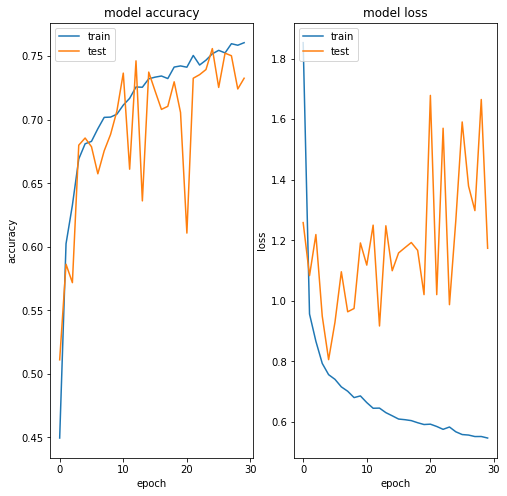

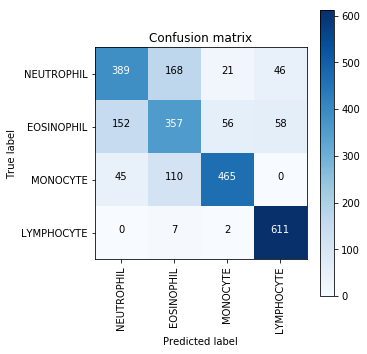

In [65]:
runKerasCNNAugment(X_train,y_trainHot,X_test,y_testHot,1)

## Results:

Using this data, we got an accuracy of 73%. 

From the confusion matrix we can observe:

Out of 624 Neutrophills, the model has predicted 389 correctly. In the remaining cases the model preicted wrongly. Model predicted 152 EOSINOPHILS as NEUTROPHILS, 45 MONOCYTES as NEUTROPHILS. 0 LYMPHOCYTES as NEUTROPHILS.

Similarly we can see the same for other cell types as well from the confusion matrix.

## CONCLUSION:

#### COMPARING THE RESULTS:

1. So for the original dataset I got an accuracy of 83 percent And the Confusion matrix looked like below: 

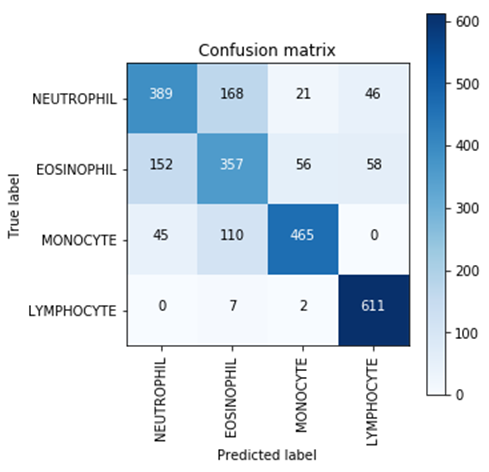

2. For the pre-processed dataset using sobel filter direcly I got an accuracy of 25 percent and the confusion matrix looked like below: 

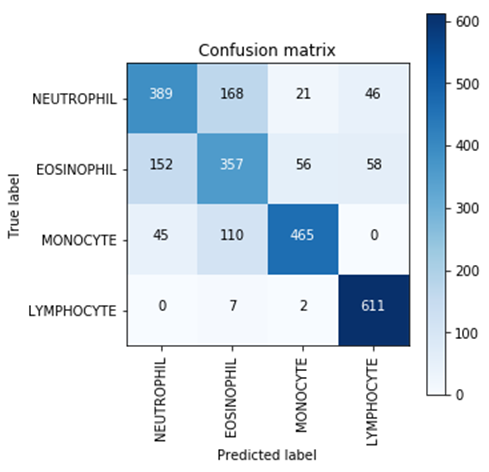

3. For the dataset where we only obtained whiteblood cells from images before transforming using sobel filter, I got an accuracy of 73 percent and the confusion matrix looked like below: 

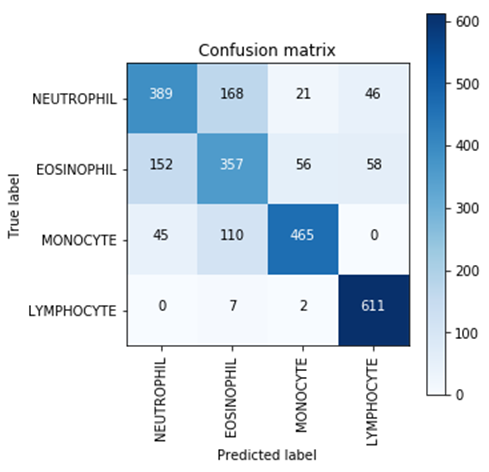


The low accuracy for the second method might be because when we detected edges of the images, we got the edges of all the other cells(WBCs) in the image. But RBCs are present in all the images. So the model might get thought all the images as same. The confusion matrix confirms the same.

The low accuracy for third methods over the first one might be because of the of the similarities with in the types of cells. Like  neutrophil and eusinophil are POLYNUCLEAR, similarly the other two types are MONONUCLEAR. So, since we detected the edges first using sobel filter in third method, the model might have predicted Neutrophil instead of eusinophil and vis-verca. It might have happened for other two types as well. The confusion matrix data also confirms the same. If we observe carefully, model predicted 152 NEUTROPHILS as EUSINOPHILS and 168 EUSINOPHILS as NEUTROPHILS.

So in the whole, we can say that Sobel's pre-processing doesn't help much in this image classification, infact it reduced the accuracy of the model.

## CONTRIBUTION:

1. Self - 70%

2. Others - 30%

## CITATIONS:

1. https://www.kaggle.com/paultimothymooney/blood-cells

2. https://github.com/Shenggan/BCCD_Dataset

3. https://medium.com/datadriveninvestor/understanding-edge-detection-sobel-operator-2aada303b900

## LICENCES:

<a rel="license" href="http://creativecommons.org/licenses/by/3.0/us/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/3.0/us/88x31.png
https://i.creativecommons.org/l/by/3.0/us/88x31.png
https://i.creativecommons.org/l/by/3.0/us/88x31.png
https://i.creativecommons.org/l/by/3.0/us/88x31.png"/></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/3.0/us/">Creative Commons Attribution 3.0 United States License</a>

Copyright 2019 Bala Krishna Chandana

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.